#### Heart Attack Prediction

### Dataset Description:

- **age:** Age of the patient
  - 0 = Female
  - 1 = Male
- **sex:** Sex of the patient
- **cp:** Chest pain type
  - 0 = Typical Angina
  - 1 = Atypical Angina
  - 2 = Non-anginal Pain
  - 3 = Asymptomatic
- **trtbps:** Resting blood pressure (in mm Hg)
- **chol:** Cholesterol level in mg/dl fetched via BMI sensor
- **fbs:** Fasting blood sugar
  - 1 = (fasting blood sugar > 120 mg/dl)
  - 0 = (fasting blood sugar <= 120 mg/dl)
- **restecg:** Resting electrocardiographic results
  - 0 = Normal
  - 1 = ST-T wave abnormality
  - 2 = Left ventricular hypertrophy
- **thalachh:** Maximum heart rate achieved
- **oldpeak:** Previous peak
- **slp:** Slope
- **caa:** Number of major vessels
- **thall:** Thallium Stress Test result
  - (0,3)
- **exng:** Exercise induced angina
  - 1 = Yes
  - 0 = No
- **output:** Target variable
  - 0 = No Attack
  - 1 = Attack


In [16]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, TFSMLayer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.losses import BinaryCrossentropy, Hinge, SquaredHinge, CategoricalCrossentropy, KLDivergence
from tensorflow.keras.utils import to_categorical
import logging
import prettytable as PrettyTable
import os
import time

In [2]:
# Suppress TensorFlow warnings
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# Set TensorFlow Autograph verbosity level to 0
tf.autograph.set_verbosity(0)

# Set default Seaborn plot size
sns.set(rc={'figure.figsize': (11.7, 8.27)})

In [3]:
# Set the random seed for reproducibility
tf.random.set_seed(1234)

# Set inter_op_parallelism_threads for better performance
# You can experiment with different values for your specific system
tf.config.threading.set_inter_op_parallelism_threads(5)

Reading the data

In [4]:
# Read the cleaned dataset
df = pd.read_csv('heartdisease_cleaned_data.csv')

# Display the first few rows of the dataset
df.head()

age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      0.6    2   

   caa  thall  output  
0    0      1       1  
1    0      2       1  
2    0      2       1  
3    0      2       1  
4    0      2       1

In [5]:
# Display concise summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [6]:
# Generate descriptive statistics of the dataset
df.describe()

age         sex          cp      trtbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     47.500000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     55.000000    1.000000    1.000000  130.000000  240.000000    0.000000   
75%     61.000000    1.000000    2.000000  140.000000  274.500000    0.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg    thalachh        exng     oldpeak         slp         caa  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean     0.528053  149.646865    0.326733    1.039604    1.399340    0.729373   
std      0.525860   22.905161    0.469794    1.161075    0.616226    1.022606   
min      0.000000   71.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000  133.500000    0.000000    0.000000    1.000000    0.000000   
50%      1.000000  153.000000    0.000000    0.800000    1.000000    0.000000   
75%      1.000000  166.000000    1.000000    1.600000    2.000000    1.000000   
max      2.000000  202.000000    1.000000    6.200000    2.000000    4.000000   

            thall      output  
count  303.000000  303.000000  
mean     2.313531    0.544554  
std      0.612277    0.498835  
min      0.000000    0.000000  
25%      2.000000    0.000000  
50%      2.000000    1.000000  
75%      3.000000    1.000000  
max      3.000000    1.000000

In [7]:
# Get the number of rows and columns in the DataFrame
df.shape[0], df.shape[1]

(303, 14)

Checking NULL values

In [8]:
# Calculate the percentage of missing values in each column
df.isnull().sum() / len(df) * 100

age         0.0
sex         0.0
cp          0.0
trtbps      0.0
chol        0.0
fbs         0.0
restecg     0.0
thalachh    0.0
exng        0.0
oldpeak     0.0
slp         0.0
caa         0.0
thall       0.0
output      0.0
dtype: float64

Checking Duplicated attributes

In [9]:
# Find duplicated rows in the DataFrame
df[df.duplicated()]

age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
164   38    1   2     138   175    0        1       173     0      0.0    2   

     caa  thall  output  
164    4      2       1

Removing Duplicated Values

In [10]:
# Drop duplicated rows from the DataFrame, keeping the first occurrence
df.drop_duplicates(keep='first', inplace=True)

In [11]:
# Get the number of rows and columns in the DataFrame
df.shape[0], df.shape[1]

(302, 14)

Computing the Correlation Matrix

In [12]:
# Calculate the correlation matrix of the DataFrame
df.corr()

age       sex        cp    trtbps      chol       fbs  \
age       1.000000 -0.094962 -0.063107  0.283121  0.207216  0.119492   
sex      -0.094962  1.000000 -0.051740 -0.057647 -0.195571  0.046022   
cp       -0.063107 -0.051740  1.000000  0.046486 -0.072682  0.096018   
trtbps    0.283121 -0.057647  0.046486  1.000000  0.125256  0.178125   
chol      0.207216 -0.195571 -0.072682  0.125256  1.000000  0.011428   
fbs       0.119492  0.046022  0.096018  0.178125  0.011428  1.000000   
restecg  -0.111590 -0.060351  0.041561 -0.115367 -0.147602 -0.083081   
thalachh -0.395235 -0.046439  0.293367 -0.048023 -0.005308 -0.007169   
exng      0.093216  0.143460 -0.392937  0.068526  0.064099  0.024729   
oldpeak   0.206040  0.098322 -0.146692  0.194600  0.050086  0.004514   
slp      -0.164124 -0.032990  0.116854 -0.122873  0.000417 -0.058654   
caa       0.302261  0.113060 -0.195356  0.099248  0.086878  0.144935   
thall     0.065317  0.211452 -0.160370  0.062870  0.096810 -0.032752   
output   -0.221476 -0.283609  0.432080 -0.146269 -0.081437 -0.026826   

           restecg  thalachh      exng   oldpeak       slp       caa  \
age      -0.111590 -0.395235  0.093216  0.206040 -0.164124  0.302261   
sex      -0.060351 -0.046439  0.143460  0.098322 -0.032990  0.113060   
cp        0.041561  0.293367 -0.392937 -0.146692  0.116854 -0.195356   
trtbps   -0.115367 -0.048023  0.068526  0.194600 -0.122873  0.099248   
chol     -0.147602 -0.005308  0.064099  0.050086  0.000417  0.086878   
fbs      -0.083081 -0.007169  0.024729  0.004514 -0.058654  0.144935   
restecg   1.000000  0.041210 -0.068807 -0.056251  0.090402 -0.083112   
thalachh  0.041210  1.000000 -0.377411 -0.342201  0.384754 -0.228311   
exng     -0.068807 -0.377411  1.000000  0.286766 -0.256106  0.125377   
oldpeak  -0.056251 -0.342201  0.286766  1.000000 -0.576314  0.236560   
slp       0.090402  0.384754 -0.256106 -0.576314  1.000000 -0.092236   
caa      -0.083112 -0.228311  0.125377  0.236560 -0.092236  1.000000   
thall    -0.010473 -0.094910  0.205826  0.209090 -0.103314  0.160085   
output    0.134874  0.419955 -0.435601 -0.429146  0.343940 -0.408992   

             thall    output  
age       0.065317 -0.221476  
sex       0.211452 -0.283609  
cp       -0.160370  0.432080  
trtbps    0.062870 -0.146269  
chol      0.096810 -0.081437  
fbs      -0.032752 -0.026826  
restecg  -0.010473  0.134874  
thalachh -0.094910  0.419955  
exng      0.205826 -0.435601  
oldpeak   0.209090 -0.429146  
slp      -0.103314  0.343940  
caa       0.160085 -0.408992  
thall     1.000000 -0.343101  
output   -0.343101  1.000000

DATA VISUALIZATION

<Axes: >

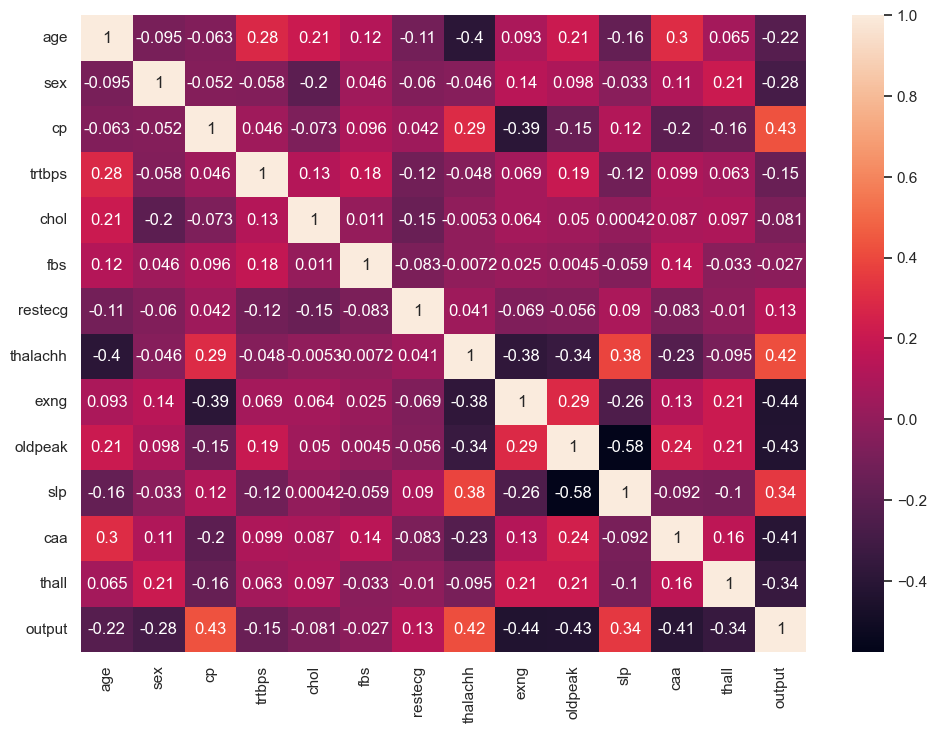

In [13]:
# Create a heatmap of the correlation matrix for the DataFrame df
# annot=True displays the correlation values on the heatmap
sns.heatmap(df.corr(), annot=True)

Number of people with sex as Male: 96
Number of people with sex Female: 206


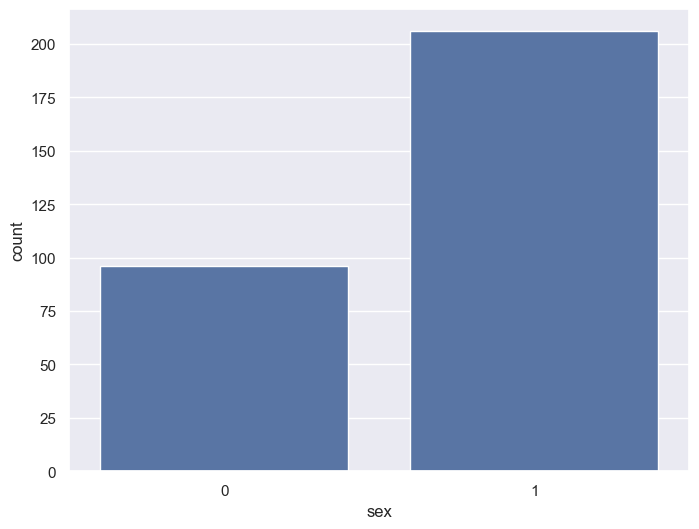

In [14]:
# Count the number of people by sex
sex_counts = df['sex'].value_counts()

# Print the counts
print(f'Number of people with sex as Male: {sex_counts[0]}')
print(f'Number of people with sex Female: {sex_counts[1]}')

# Plot the counts using seaborn
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="sex")
plt.show()

Counts of each chest pain type:
cp
0    143
2     86
1     50
3     23
Name: count, dtype: int64


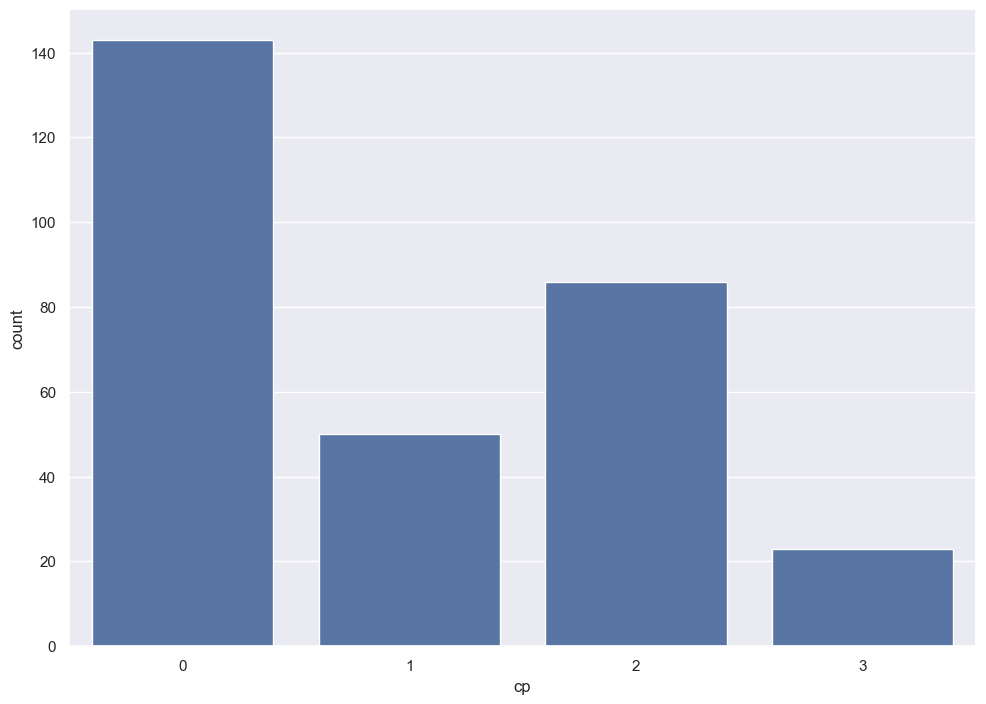

In [15]:
# Count the number of occurrences of each chest pain type
cp_counts = df['cp'].value_counts()

# Print the counts of each chest pain type
print("Counts of each chest pain type:")
print(cp_counts)

# Visualize the distribution of chest pain types
sns.countplot(data=df, x="cp")
plt.show()

Counts of each value in the 'chol' column:
chol
204    6
197    6
234    6
212    5
254    5
      ..
284    1
224    1
167    1
276    1
131    1
Name: count, Length: 152, dtype: int64


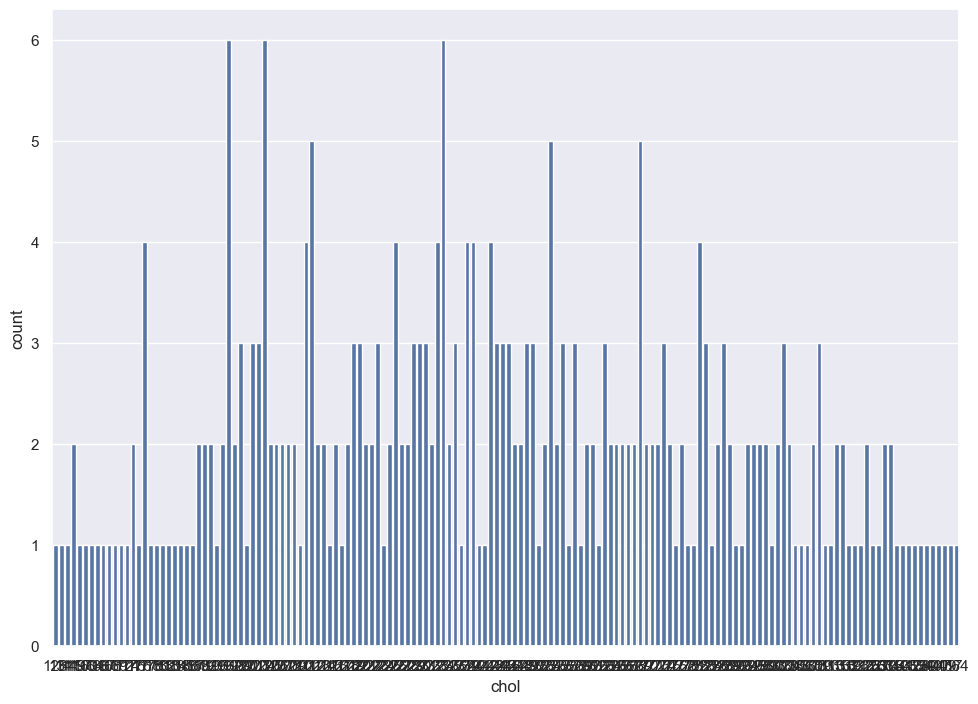

In [16]:
# Count the number of occurrences of each value in the "chol" column
chol_counts = df['chol'].value_counts()

# Print the counts of each value in the "chol" column
print("Counts of each value in the 'chol' column:")
print(chol_counts)

# Visualize the distribution of values in the "chol" column
sns.countplot(data=df, x="chol")
plt.show()

Counts of each value in the 'fbs' column:
fbs
0    257
1     45
Name: count, dtype: int64


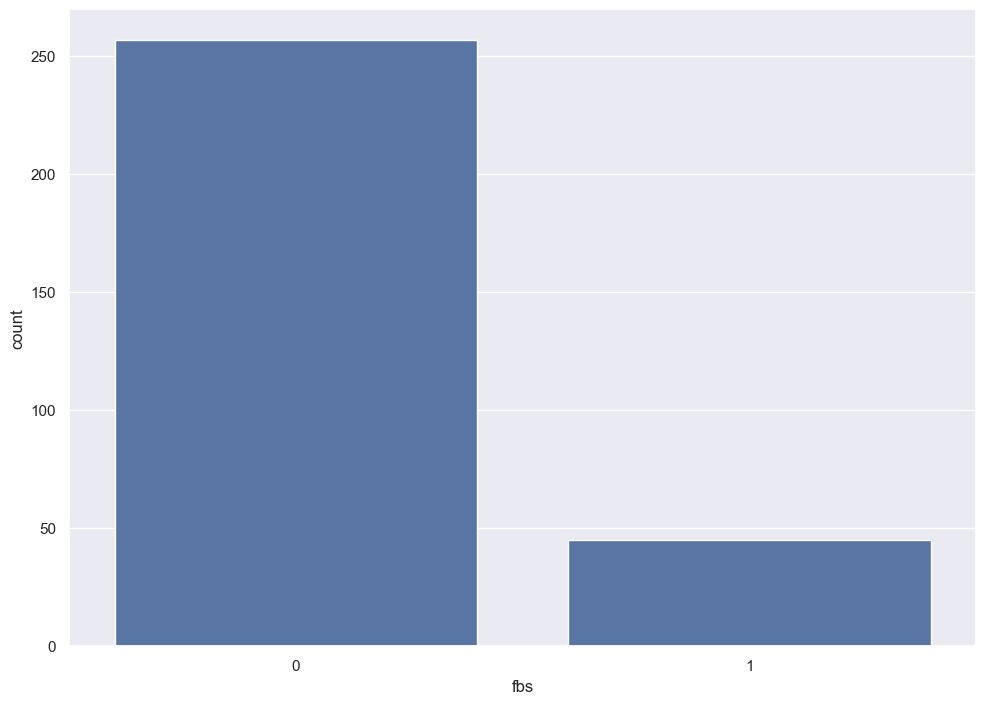

In [17]:
# Count the number of occurrences of each value in the "fbs" column
fbs_counts = df['fbs'].value_counts()

# Print the counts of each value in the "fbs" column
print("Counts of each value in the 'fbs' column:")
print(fbs_counts)

# Visualize the distribution of values in the "fbs" column
sns.countplot(data=df, x="fbs")
plt.show()

Counts of each value in the 'restecg' column:
restecg
1    151
0    147
2      4
Name: count, dtype: int64


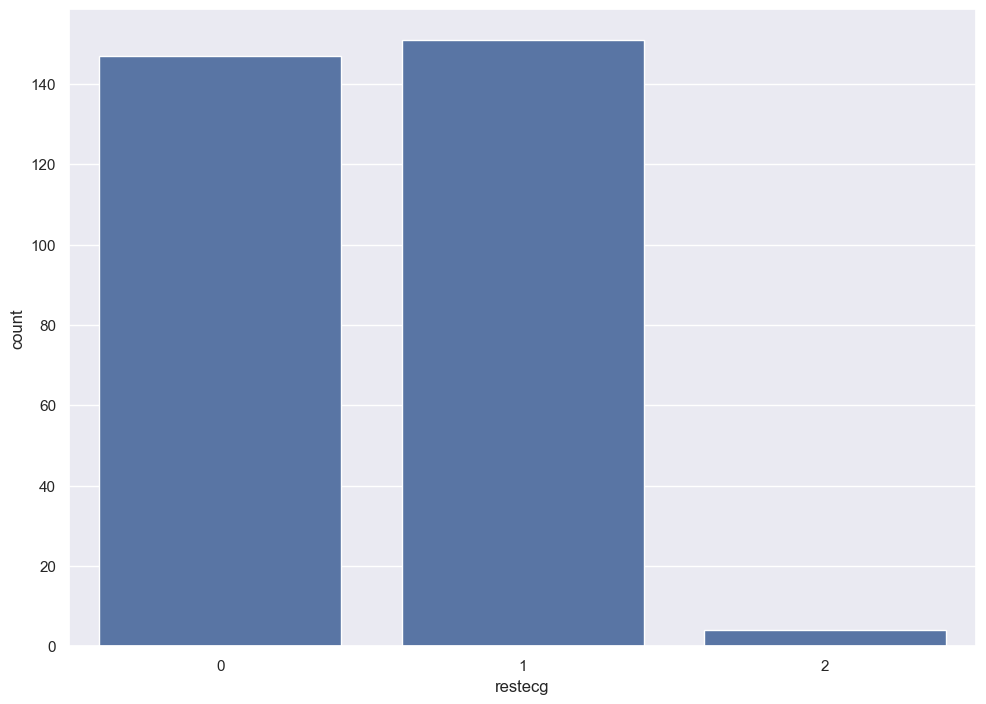

In [18]:
# Count the number of occurrences of each value in the "restecg" column
restecg_counts = df['restecg'].value_counts()

# Print the counts of each value in the "restecg" column
print("Counts of each value in the 'restecg' column:")
print(restecg_counts)

# Visualize the distribution of values in the "restecg" column
sns.countplot(data=df, x="restecg")
plt.show()

Counts of each value in the 'exng' column:
exng
0    203
1     99
Name: count, dtype: int64


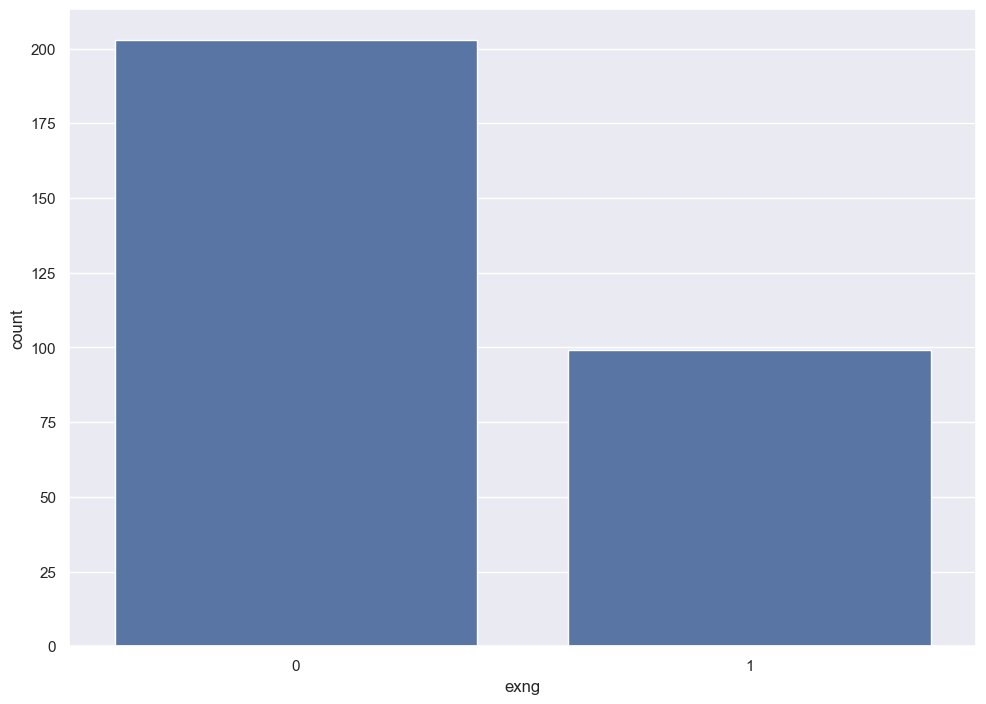

In [19]:
# Count the number of occurrences of each value in the "exng" column
exng_counts = df['exng'].value_counts()

# Print the counts of each value in the "exng" column
print("Counts of each value in the 'exng' column:")
print(exng_counts)

# Visualize the distribution of values in the "exng" column using a countplot
sns.countplot(data=df, x="exng")
plt.show()

Counts of each value in the 'oldpeak' column:
oldpeak
0.0    98
1.2    17
1.0    14
0.6    14
1.4    13
0.8    13
0.2    12
1.6    11
1.8    10
0.4     9
2.0     9
0.1     7
2.8     6
2.6     6
1.5     5
3.0     5
1.9     5
0.5     5
3.6     4
2.2     4
2.4     3
0.9     3
3.4     3
4.0     3
0.3     3
2.3     2
3.2     2
2.5     2
4.2     2
1.1     2
3.1     1
0.7     1
3.5     1
6.2     1
1.3     1
5.6     1
2.9     1
2.1     1
3.8     1
4.4     1
Name: count, dtype: int64


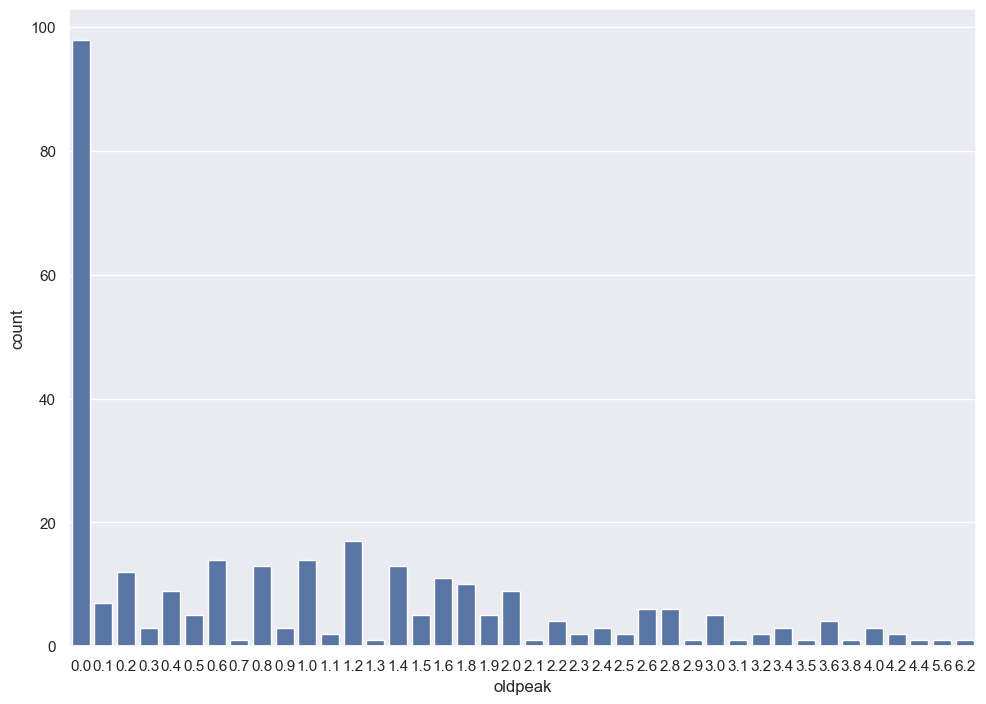

In [20]:
# Count the number of occurrences of each value in the "oldpeak" column
oldpeak_counts = df['oldpeak'].value_counts()

# Print the counts of each value in the "oldpeak" column
print("Counts of each value in the 'oldpeak' column:")
print(oldpeak_counts)

# Visualize the distribution of values in the "oldpeak" column using a countplot
sns.countplot(data=df, x="oldpeak")
plt.show()

Counts of each value in the 'slp' column:
slp
2    141
1    140
0     21
Name: count, dtype: int64


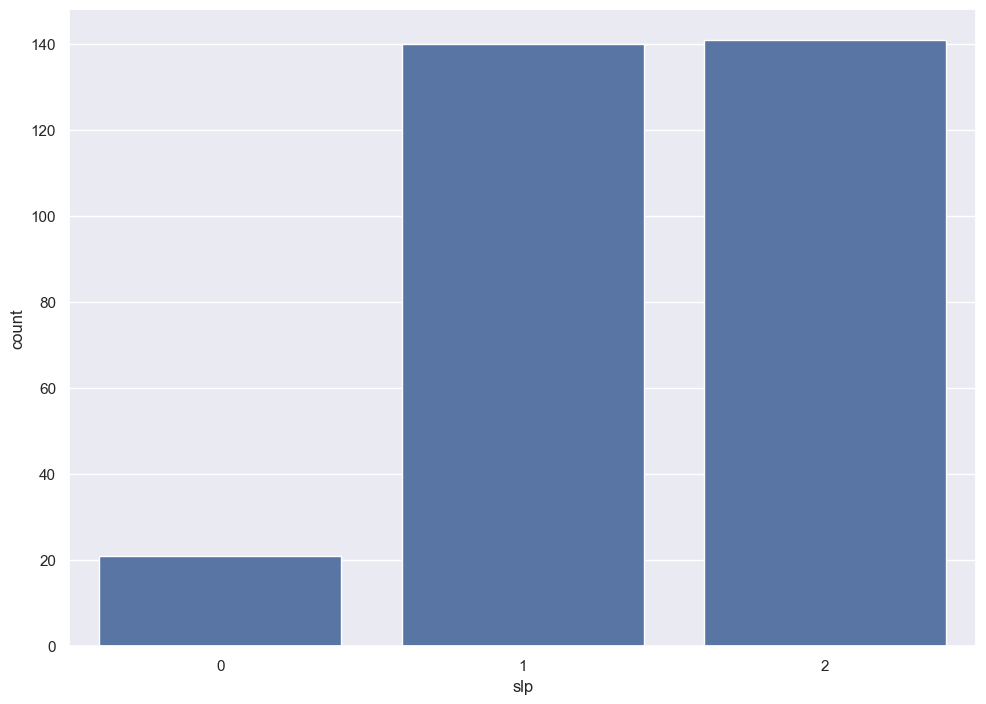

In [21]:
# Count the number of occurrences of each value in the "slp" column
slp_counts = df['slp'].value_counts()

# Print the counts of each value in the "slp" column
print("Counts of each value in the 'slp' column:")
print(slp_counts)

# Visualize the distribution of values in the "slp" column using a countplot
sns.countplot(data=df, x="slp")
plt.show()

Counts of each value in the 'caa' column:
caa
0    175
1     65
2     38
3     20
4      4
Name: count, dtype: int64


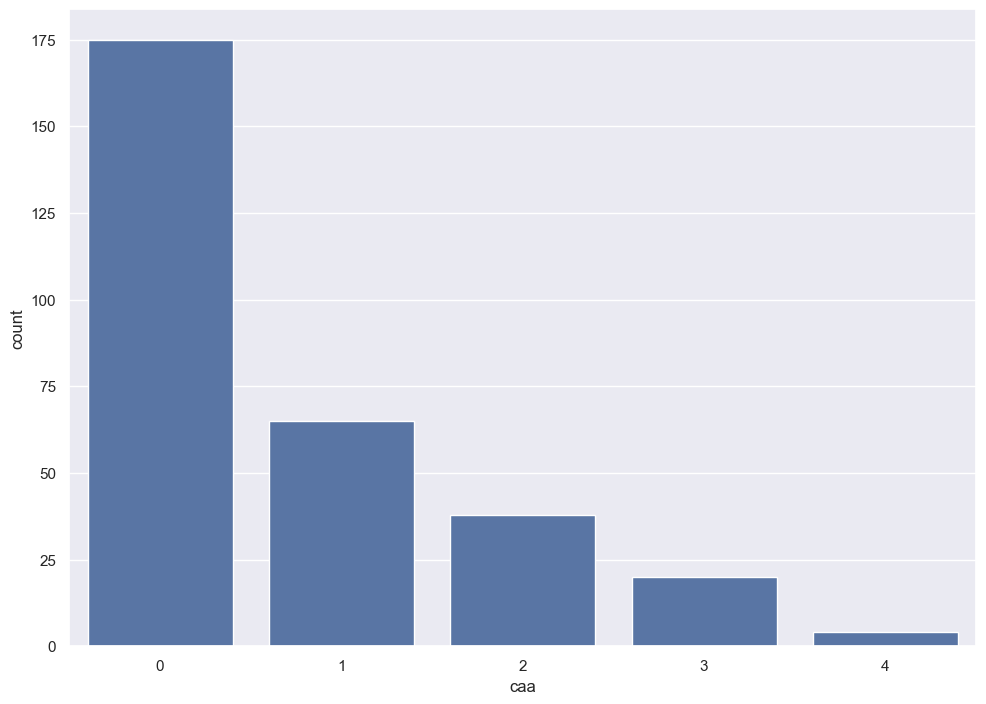

In [22]:
# Count the number of occurrences of each value in the "caa" column
caa_counts = df['caa'].value_counts()

# Print the counts of each value in the "caa" column
print("Counts of each value in the 'caa' column:")
print(caa_counts)

# Visualize the distribution of values in the "caa" column using a countplot
sns.countplot(data=df, x="caa")
plt.show()

Counts of each value in the 'thall' column:
thall
2    165
3    117
1     18
0      2
Name: count, dtype: int64


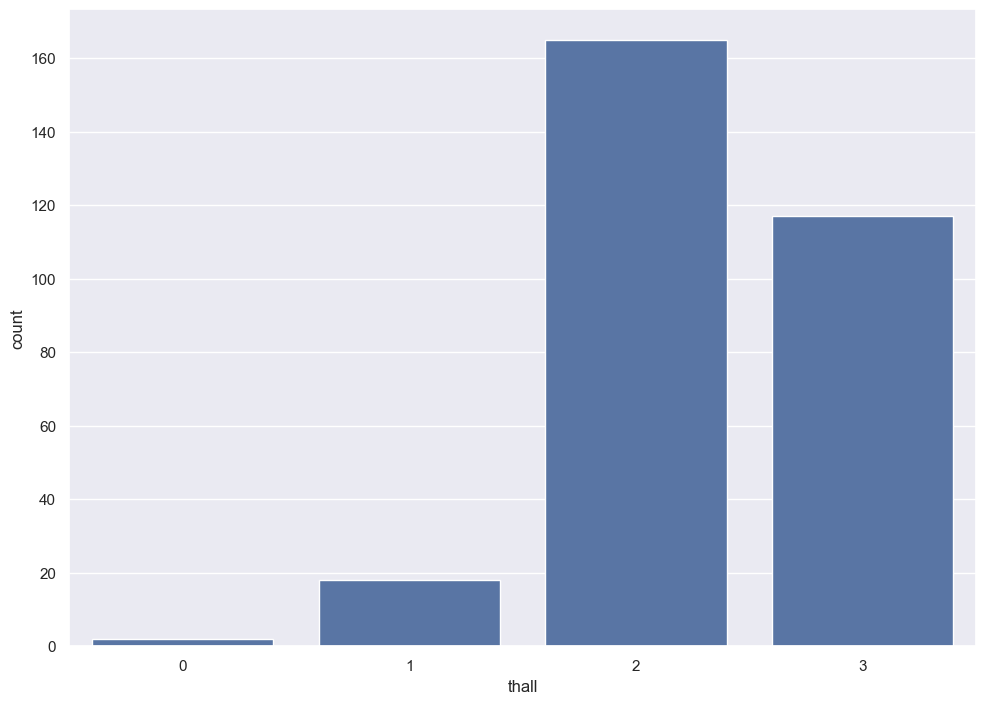

In [23]:
# Count the number of occurrences of each value in the "thall" column
thall_counts = df['thall'].value_counts()

# Print the counts of each value in the "thall" column
print("Counts of each value in the 'thall' column:")
print(thall_counts)

# Visualize the distribution of values in the "thall" column using a countplot
sns.countplot(data=df, x="thall")
plt.show()

Counts of each value in the 'output' column:
output
1    164
0    138
Name: count, dtype: int64


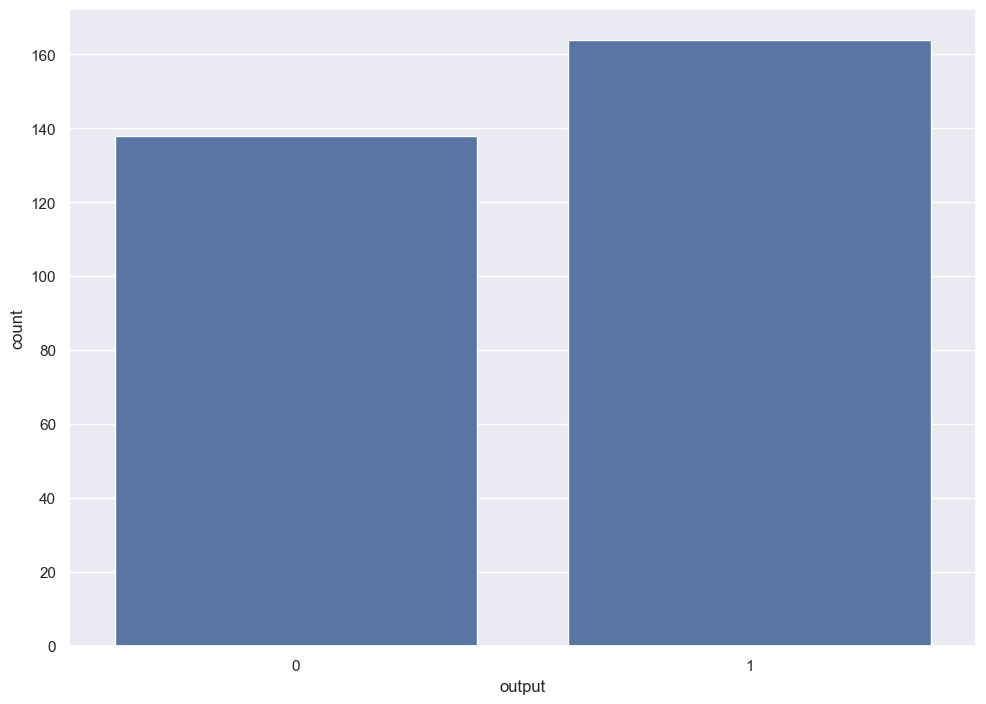

In [24]:
# Count the number of occurrences of each value in the "output" column
output_counts = df['output'].value_counts()

# Print the counts of each value in the "output" column
print("Counts of each value in the 'output' column:")
print(output_counts)

# Visualize the distribution of values in the "output" column using a countplot
sns.countplot(data=df, x="output")
plt.show()

<Figure size 1000x1000 with 0 Axes>

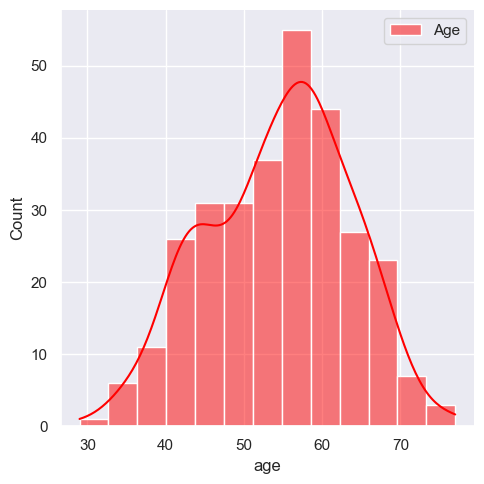

In [25]:
# Set the size of the figure
plt.figure(figsize=(10, 10))

# Create a distribution plot for the "age" column
sns.displot(df.age, color="red", label="Age", kde=True)

# Add a legend
plt.legend()

# Display the plot
plt.show()

<Figure size 2000x2000 with 0 Axes>

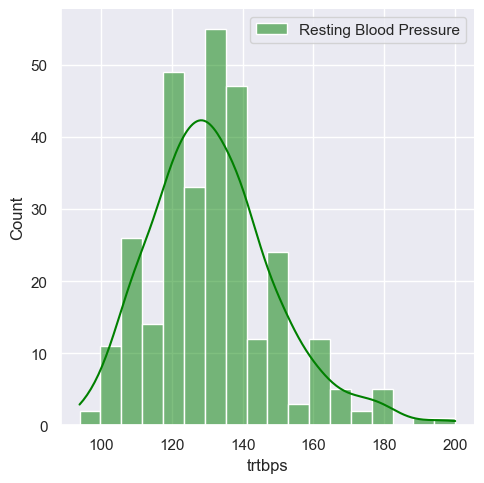

In [26]:
# Set the size of the figure
plt.figure(figsize=(20, 20))

# Create a distribution plot for the "trtbps" (Resting Blood Pressure) column
sns.displot(df.trtbps, color="green", label="Resting Blood Pressure", kde=True)

# Add a legend
plt.legend()

Heart Attack Vs Age

C:\Users\piyus\AppData\Local\Temp\ipykernel_11744\3403143332.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['output'] == 0]["age"], color='green', label='No attack')
C:\Users\piyus\AppData\Local\Temp\ipykernel_11744\3403143332.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df[

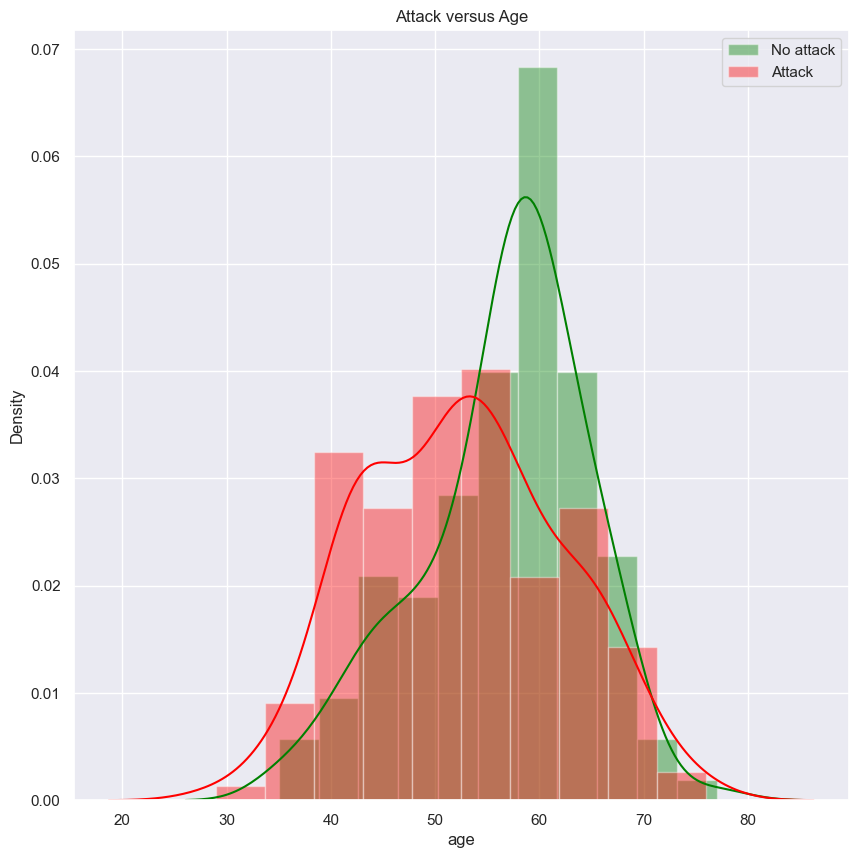

In [27]:
# Set the size of the figure
plt.figure(figsize=(10, 10))

# Plot the distribution of age for patients with output 0 (No attack) in green
sns.distplot(df[df['output'] == 0]["age"], color='green', label='No attack')

# Plot the distribution of age for patients with output 1 (Attack) in red
sns.distplot(df[df['output'] == 1]["age"], color='red', label='Attack')

# Add a title to the plot
plt.title('Attack versus Age')

# Add a legend
plt.legend()

# Show the plot
plt.show()

Cholrestrol versus age

C:\Users\piyus\AppData\Local\Temp\ipykernel_11744\4059806457.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['output'] == 0]["chol"], color='green', label='No attack')
C:\Users\piyus\AppData\Local\Temp\ipykernel_11744\4059806457.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df

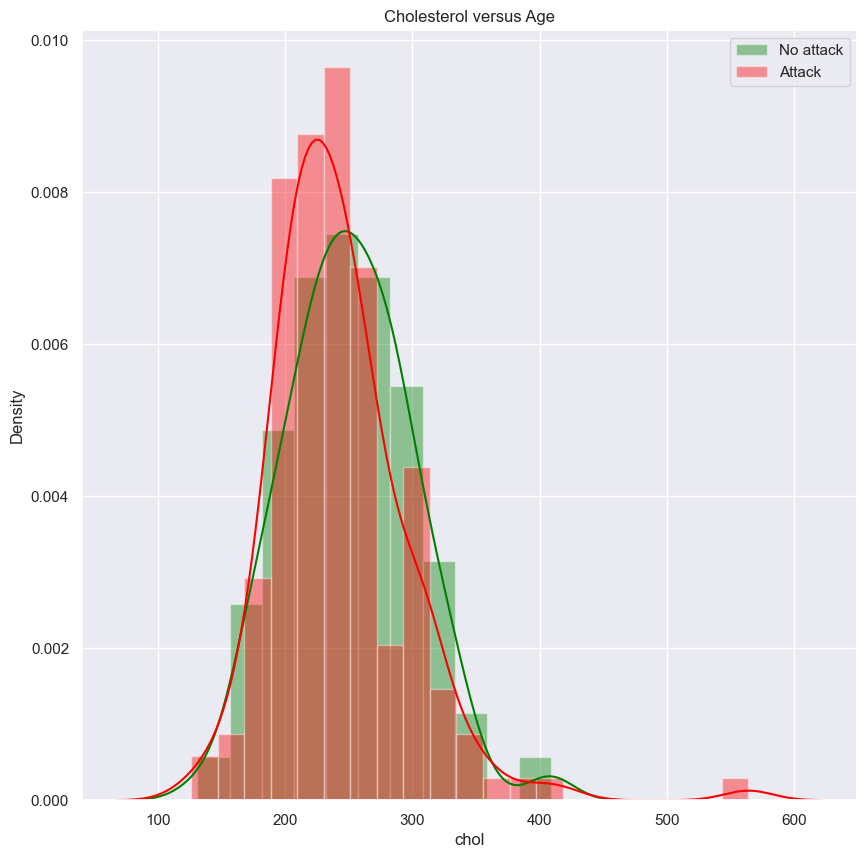

In [28]:
# Set the size of the figure
plt.figure(figsize=(10, 10))

# Plot the distribution of cholesterol for patients with output 0 (No attack) in green
sns.distplot(df[df['output'] == 0]["chol"], color='green', label='No attack')

# Plot the distribution of cholesterol for patients with output 1 (Attack) in red
sns.distplot(df[df['output'] == 1]["chol"], color='red', label='Attack')

# Add a title to the plot
plt.title('Cholesterol versus Age')

# Add a legend
plt.legend()

# Show the plot
plt.show()

trtbps versus age 

C:\Users\piyus\AppData\Local\Temp\ipykernel_11744\2693460542.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['output'] == 0]["trtbps"], color='green', label='No attack')
C:\Users\piyus\AppData\Local\Temp\ipykernel_11744\2693460542.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[

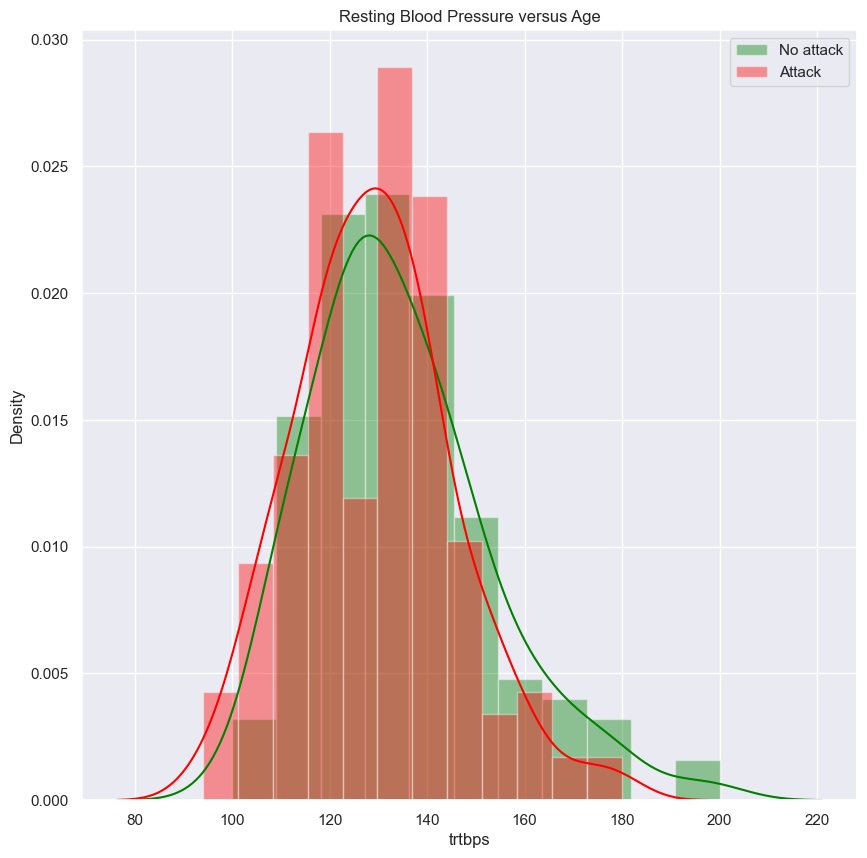

In [29]:
# Set the size of the figure
plt.figure(figsize=(10, 10))

# Plot the distribution of resting blood pressure for patients with output 0 (No attack) in green
sns.distplot(df[df['output'] == 0]["trtbps"], color='green', label='No attack')

# Plot the distribution of resting blood pressure for patients with output 1 (Attack) in red
sns.distplot(df[df['output'] == 1]["trtbps"], color='red', label='Attack')

# Add a title to the plot
plt.title('Resting Blood Pressure versus Age')

# Add a legend
plt.legend()

# Show the plot
plt.show()

thalachh versus age

C:\Users\piyus\AppData\Local\Temp\ipykernel_11744\3117581427.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['output'] == 0]["thalachh"], color='green', label='No attack')
C:\Users\piyus\AppData\Local\Temp\ipykernel_11744\3117581427.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(d

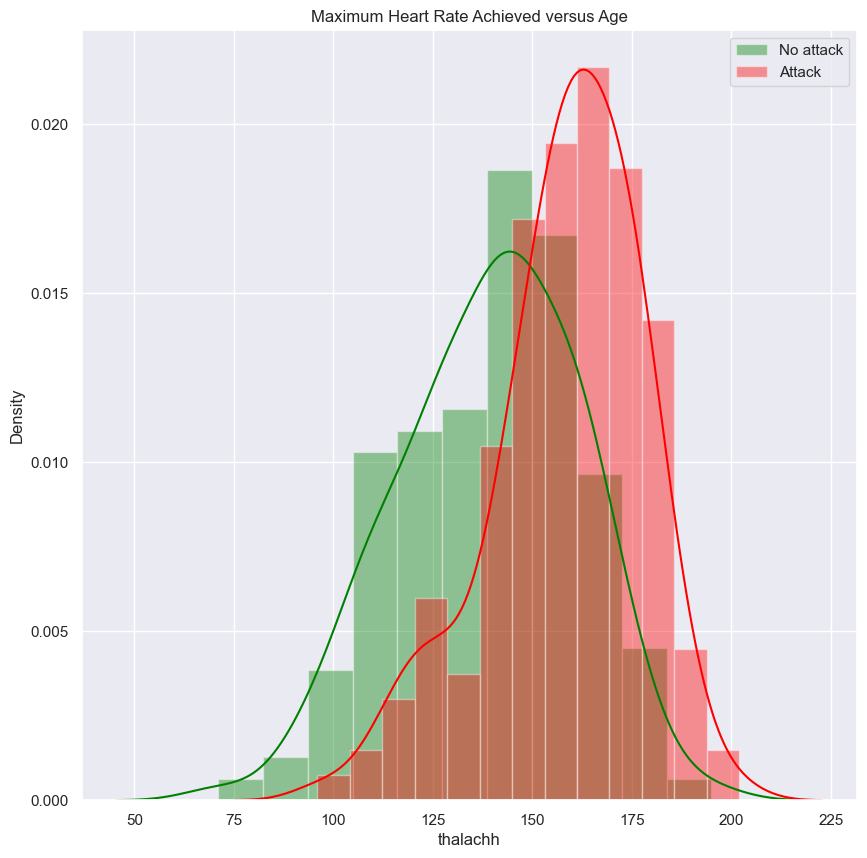

In [30]:
# Set the size of the figure
plt.figure(figsize=(10, 10))

# Plot the distribution of maximum heart rate achieved for patients with output 0 (No attack) in green
sns.distplot(df[df['output'] == 0]["thalachh"], color='green', label='No attack')

# Plot the distribution of maximum heart rate achieved for patients with output 1 (Attack) in red
sns.distplot(df[df['output'] == 1]["thalachh"], color='red', label='Attack')

# Add a title to the plot
plt.title('Maximum Heart Rate Achieved versus Age')

# Add a legend
plt.legend()

# Show the plot
plt.show()

Pair Plot

<Figure size 2000x2000 with 0 Axes>

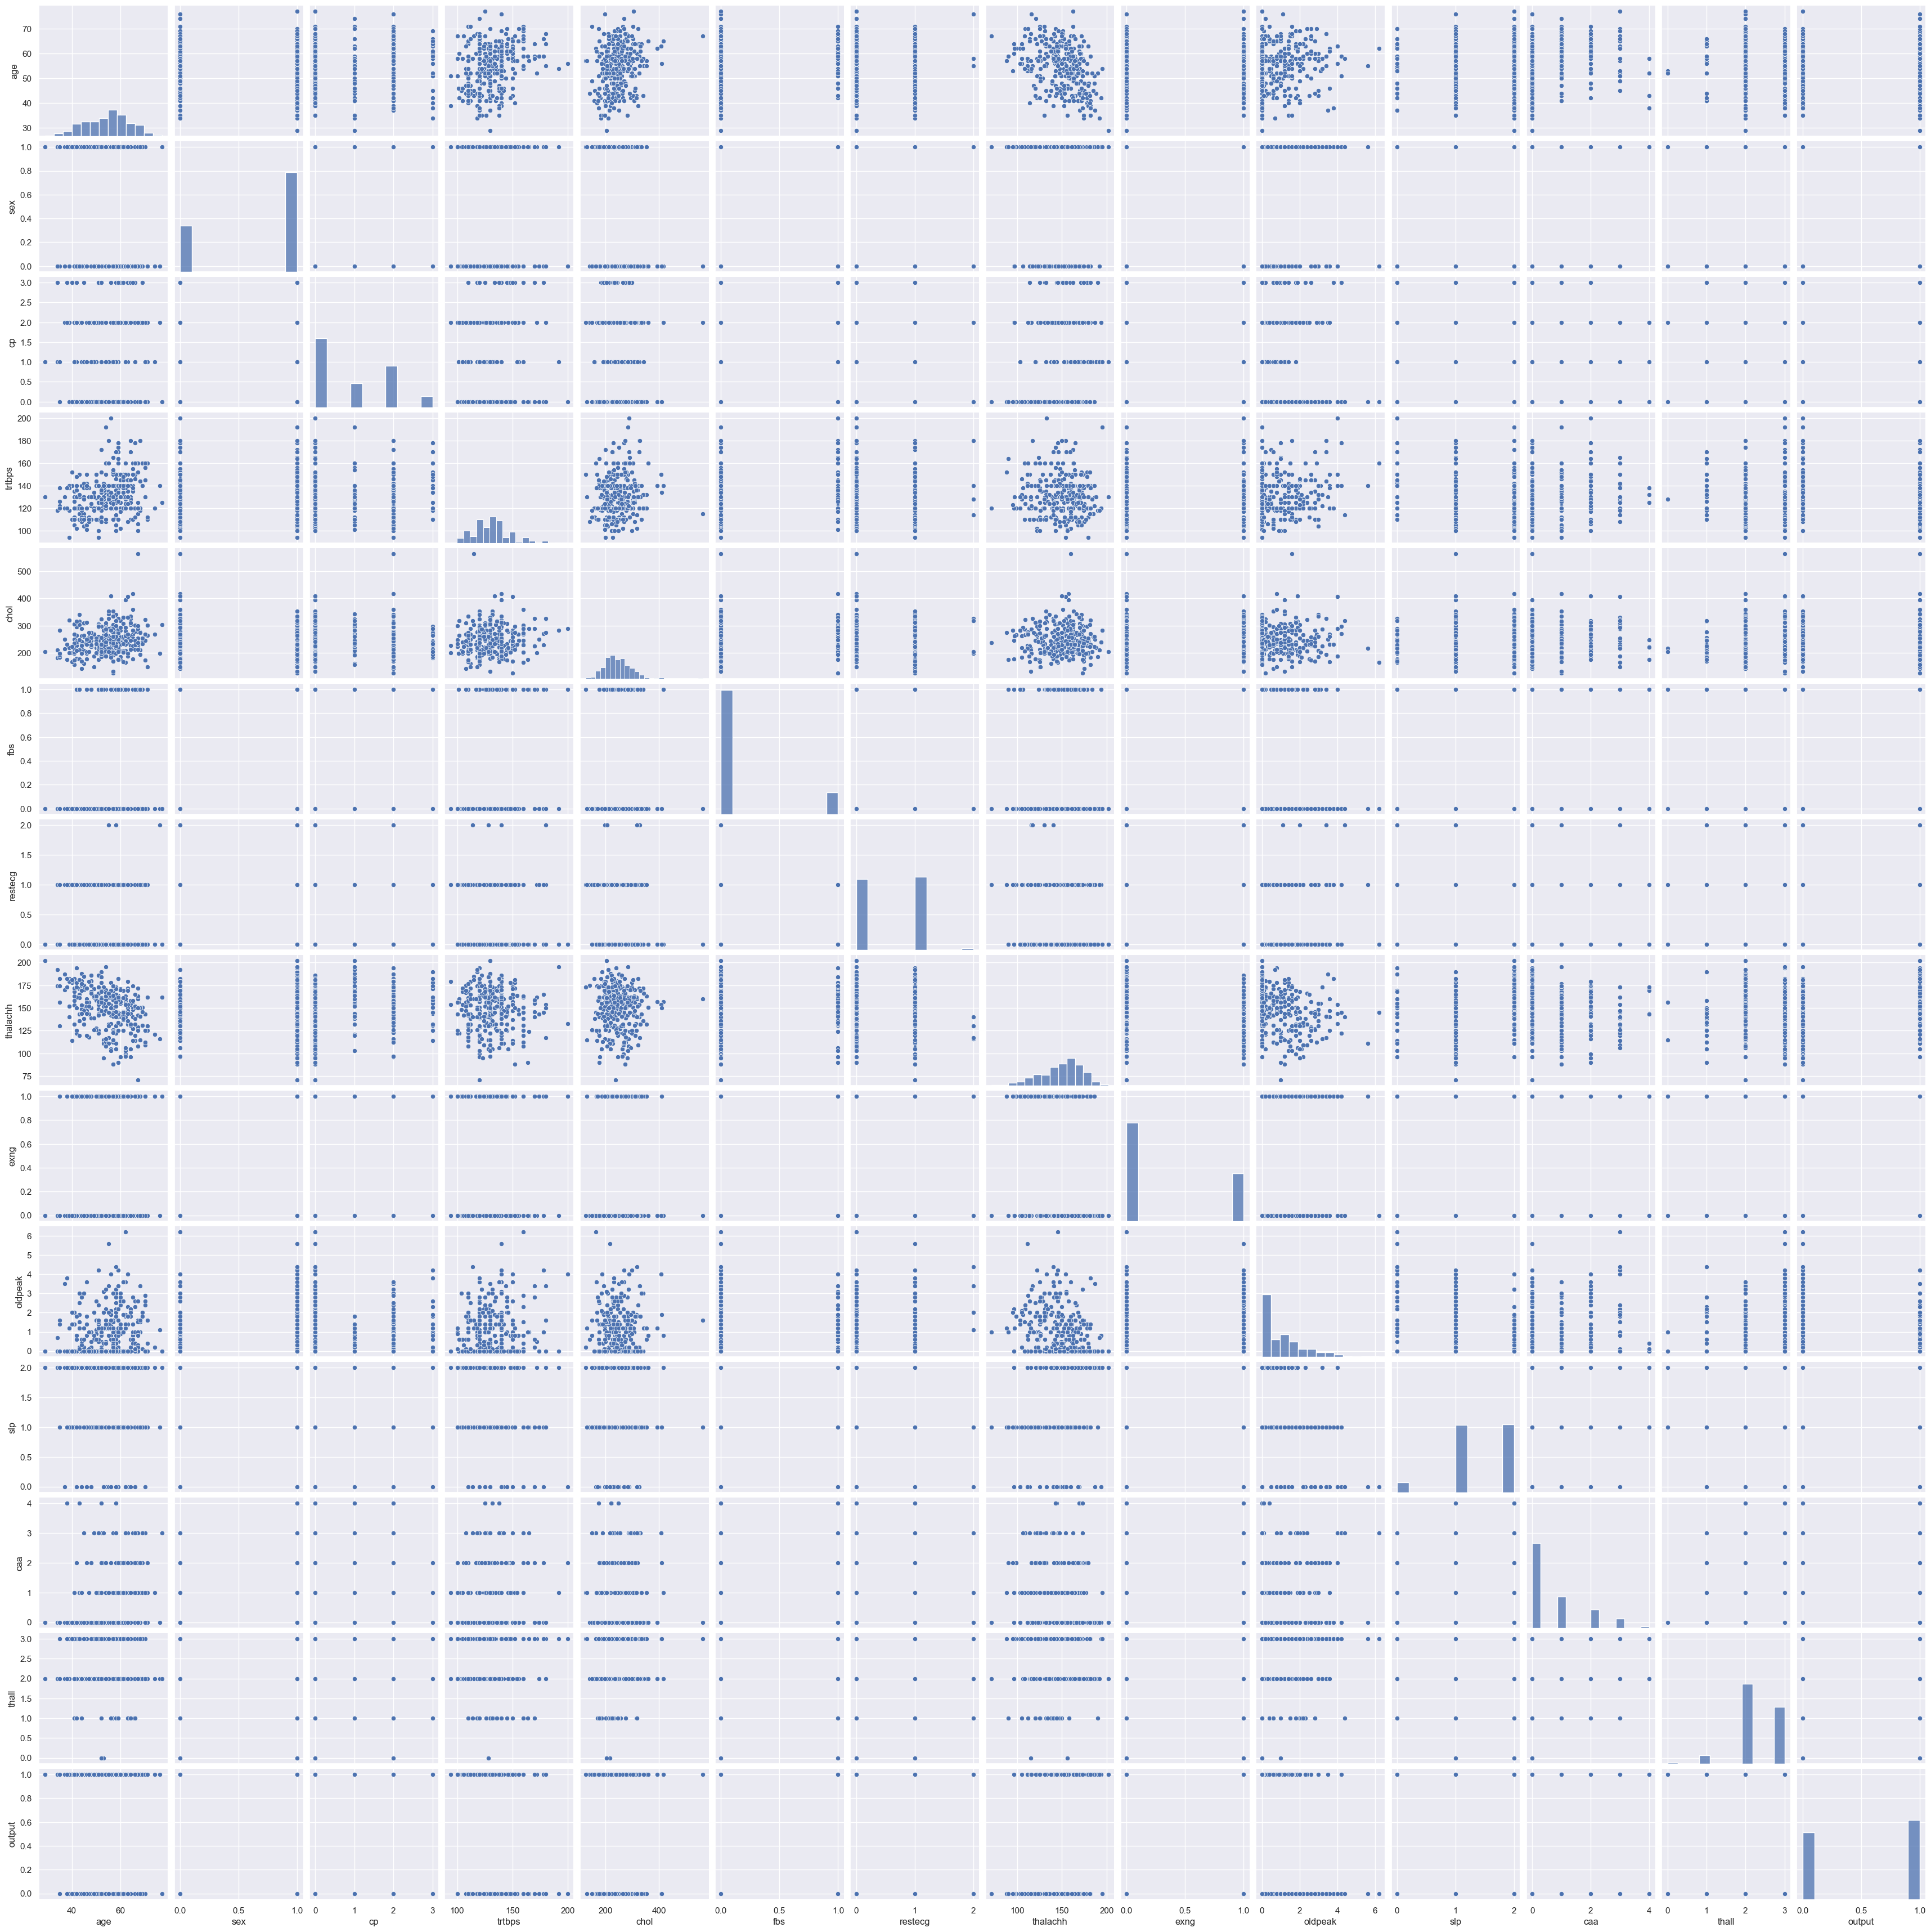

In [31]:
# Set the size of the figure
plt.figure(figsize=(20, 20))

# Create a pairwise plot of all numerical variables in the DataFrame
sns.pairplot(df)

# Show the plot
plt.show()

DATA PROCESSING

In [12]:
# Extract feature variables (all columns except the first and last) and target variable (last column)
x = df.iloc[:, 1:-1].values
y = df.iloc[:, -1].values

# Print the feature variables (x) and target variable (y)
x, y

(array([[  1.,   3., 145., ...,   0.,   0.,   1.],
        [  1.,   2., 130., ...,   0.,   0.,   2.],
        [  0.,   1., 130., ...,   2.,   0.,   2.],
        ...,
        [  1.,   0., 144., ...,   1.,   2.,   3.],
        [  1.,   0., 130., ...,   1.,   1.,   3.],
        [  0.,   1., 130., ...,   1.,   1.,   2.]]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0,

Splitting the Dataset

In [13]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [14]:
# Initialize StandardScaler
scaler = StandardScaler()

# Standardize the training data (x_train)
x_train = scaler.fit_transform(x_train)

# Standardize the testing data (x_test) using the same scaler as training data
x_test = scaler.transform(x_test)

Model Initializations

In [35]:
# Define a list of optimizers, losses, and EarlyStopping parameters to try
optimizers = [Adam, RMSprop, SGD]
losses = [BinaryCrossentropy(), Hinge(), SquaredHinge()]
early_stopping_params = [(5, True), (10, True), (5, False)]

In [36]:
# Define k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

1.  multi-layer perceptron Model

In [37]:
best_accuracy_MLPM = 0.0 # Initialize best accuracy value to
best_params_MLPM = {} # Initialize best parameters
best_model_MLPM = None # Initialize best model to None

In [38]:
# Perform grid search
for optimizer_class in optimizers:
    for loss in losses:
        for early_stopping_param in early_stopping_params:
            accuracies_MLPM = []
            for train_index, val_index in kfold.split(x_train, y_train):
                x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
                y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
                
                # Define your model architecture
                model_MLPM = Sequential([
                    Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
                    Dropout(0.5),
                    Dense(32, activation='relu'),
                    Dropout(0.3),
                    Dense(16, activation='relu'),
                    Dropout(0.2),
                    Dense(1, activation='sigmoid')
                ])

                # Create optimizer instance
                optimizer = optimizer_class()

                # Compile the model
                model_MLPM.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

                # Define early stopping callback
                early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_param[0], restore_best_weights=early_stopping_param[1])

                # Train the model
                model_MLPM.fit(x_train_fold, y_train_fold, epochs=75, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

                # Evaluate the model on validation data
                _, accuracy = model_MLPM.evaluate(x_val_fold, y_val_fold)
                accuracies_MLPM.append(accuracy)

            # Calculate mean accuracy
            mean_accuracy_MLPM = np.mean(accuracies_MLPM)
            print(f"Optimizer: {optimizer_class.__name__}, Loss: {loss.__class__.__name__}, Early Stopping: {early_stopping_param}, Mean Accuracy: {mean_accuracy_MLPM}")

            # Update best parameters if the mean accuracy is higher
            if mean_accuracy_MLPM > best_accuracy_MLPM:
                best_accuracy_MLPM = mean_accuracy_MLPM
                best_params_MLPM['optimizer'] = optimizer_class.__name__
                best_params_MLPM['loss'] = loss.__class__.__name__
                best_params_MLPM['early_stopping'] = early_stopping_param
                best_model_MLPM = model_MLPM

# Print and save the best model
print("Best Parameters:")
print(best_params_MLPM)
print("Best Mean Accuracy:", best_accuracy_MLPM)

# Save the trained model to disk
if best_model_MLPM is not None:
    tf.saved_model.save(best_model_MLPM, 'saved_model/best_multi-layer_perceptron_Model')

Epoch 1/75


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.5259 - loss: 0.7565 - val_accuracy: 0.5641 - val_loss: 0.7055
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5502 - loss: 0.7270 - val_accuracy: 0.5897 - val_loss: 0.6834
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5258 - loss: 0.7216 - val_accuracy: 0.6667 - val_loss: 0.6649
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5611 - loss: 0.7089 - val_accuracy: 0.7949 - val_loss: 0.6489
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5641 - loss: 0.6710 - val_accuracy: 0.7949 - val_loss: 0.6357
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5828 - loss: 0.6696 - val_accuracy: 0.7949 - val_loss: 0.6229
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6432 - loss: 0.6599 - val_accuracy: 0.7949 - val_loss: 0.6093
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6619 - loss: 0.6431 - val_accuracy: 0.8205 - val_loss: 0.5972
Epoch 9/75


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.5271 - loss: 0.7219 - val_accuracy: 0.5385 - val_loss: 0.6862
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6184 - loss: 0.7084 - val_accuracy: 0.6154 - val_loss: 0.6682
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5463 - loss: 0.6932 - val_accuracy: 0.6667 - val_loss: 0.6527
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5763 - loss: 0.6841 - val_accuracy: 0.7436 - val_loss: 0.6389
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6727 - loss: 0.6262 - val_accuracy: 0.7179 - val_loss: 0.6236
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5872 - loss: 0.6562 - val_accuracy: 0.7436 - val_loss: 0.6086
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6271 - loss: 0.6342 - val_accuracy: 0.7179 - val_loss: 0.5941
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6780 - loss: 0.6121 - val_accuracy: 0.7436 - val_loss: 0.5780
Epoch 9/75
5/

C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.5133 - loss: 0.7013 - val_accuracy: 0.4872 - val_loss: 0.6736
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4581 - loss: 0.7087 - val_accuracy: 0.5128 - val_loss: 0.6597
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5050 - loss: 0.6906 - val_accuracy: 0.6154 - val_loss: 0.6481
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5958 - loss: 0.6609 - val_accuracy: 0.6923 - val_loss: 0.6383
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5915 - loss: 0.6489 - val_accuracy: 0.6667 - val_loss: 0.6301
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6306 - loss: 0.6559 - val_accuracy: 0.6923 - val_loss: 0.6231
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5515 - loss: 0.6625 - val_accuracy: 0.7179 - val_loss: 0.6177
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6458 - loss: 0.6428 - val_accuracy: 0.7949 - val_loss: 0.6109
Epoch 9/75


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.4559 - loss: 0.9622 - val_accuracy: 0.5128 - val_loss: 0.9770
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4729 - loss: 0.9509 - val_accuracy: 0.5897 - val_loss: 0.9689
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6106 - loss: 0.9289 - val_accuracy: 0.6410 - val_loss: 0.9597
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4859 - loss: 0.9501 - val_accuracy: 0.7179 - val_loss: 0.9499
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6119 - loss: 0.9057 - val_accuracy: 0.7179 - val_loss: 0.9390
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6067 - loss: 0.9055 - val_accuracy: 0.7949 - val_loss: 0.9273
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6510 - loss: 0.9068 - val_accuracy: 0.8205 - val_loss: 0.9158
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6219 - loss: 0.9064 - val_accuracy: 0.8205 - val_loss: 0.9035
Epoch 9/75


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.5432 - loss: 0.9465 - val_accuracy: 0.5128 - val_loss: 0.9859
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5189 - loss: 0.9453 - val_accuracy: 0.4872 - val_loss: 0.9707
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5928 - loss: 0.9261 - val_accuracy: 0.5128 - val_loss: 0.9558
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5867 - loss: 0.9214 - val_accuracy: 0.5641 - val_loss: 0.9409
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5811 - loss: 0.8994 - val_accuracy: 0.6154 - val_loss: 0.9256
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5780 - loss: 0.9039 - val_accuracy: 0.6667 - val_loss: 0.9100
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6124 - loss: 0.8894 - val_accuracy: 0.6923 - val_loss: 0.8953
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5793 - loss: 0.8944 - val_accuracy: 0.6923 - val_loss: 0.8809
Epoch 9/75
5

C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.4603 - loss: 0.9509 - val_accuracy: 0.5128 - val_loss: 0.9868
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5437 - loss: 0.9474 - val_accuracy: 0.6154 - val_loss: 0.9804
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5910 - loss: 0.9248 - val_accuracy: 0.6667 - val_loss: 0.9743
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5589 - loss: 0.9345 - val_accuracy: 0.6667 - val_loss: 0.9676
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6788 - loss: 0.9141 - val_accuracy: 0.6667 - val_loss: 0.9605
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6606 - loss: 0.9056 - val_accuracy: 0.6923 - val_loss: 0.9523
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6914 - loss: 0.8917 - val_accuracy: 0.6923 - val_loss: 0.9434
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7419 - loss: 0.8795 - val_accuracy: 0.6923 - val_loss: 0.9319
Epoch 9/75
5/5 ━━

C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.4842 - loss: 1.2595 - val_accuracy: 0.4615 - val_loss: 1.2907
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5346 - loss: 1.2076 - val_accuracy: 0.5385 - val_loss: 1.2436
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6349 - loss: 1.1637 - val_accuracy: 0.5897 - val_loss: 1.1994
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5789 - loss: 1.0962 - val_accuracy: 0.6410 - val_loss: 1.1577
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5989 - loss: 1.1101 - val_accuracy: 0.6410 - val_loss: 1.1208
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6323 - loss: 1.0365 - val_accuracy: 0.6410 - val_loss: 1.0850
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5550 - loss: 1.0393 - val_accuracy: 0.6154 - val_loss: 1.0511
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5068 - loss: 1.0244 - val_accuracy: 0.6410 - val_loss: 1.0194
Epoch 9/75
5/

C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.5298 - loss: 1.1973 - val_accuracy: 0.5897 - val_loss: 1.2206
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5077 - loss: 1.1782 - val_accuracy: 0.5385 - val_loss: 1.1817
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5398 - loss: 1.1334 - val_accuracy: 0.6410 - val_loss: 1.1484
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5580 - loss: 1.0715 - val_accuracy: 0.5897 - val_loss: 1.1156
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5402 - loss: 1.0600 - val_accuracy: 0.5897 - val_loss: 1.0807
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4685 - loss: 1.0520 - val_accuracy: 0.5897 - val_loss: 1.0468
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4733 - loss: 1.0732 - val_accuracy: 0.5641 - val_loss: 1.0164
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5080 - loss: 1.0080 - val_accuracy: 0.5641 - val_loss: 0.9876
Epoch 9/75
5/

C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.5645 - loss: 1.0683 - val_accuracy: 0.6923 - val_loss: 1.0865
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5645 - loss: 1.0032 - val_accuracy: 0.6410 - val_loss: 1.0444
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5697 - loss: 1.0099 - val_accuracy: 0.5897 - val_loss: 1.0083
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5094 - loss: 0.9937 - val_accuracy: 0.5897 - val_loss: 0.9756
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5706 - loss: 0.9281 - val_accuracy: 0.5641 - val_loss: 0.9476
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5536 - loss: 0.8930 - val_accuracy: 0.5641 - val_loss: 0.9247
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5237 - loss: 0.9078 - val_accuracy: 0.5641 - val_loss: 0.9063
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5393 - loss: 0.9298 - val_accuracy: 0.5641 - val_loss: 0.8922
Epoch 9/75
5

C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.5002 - loss: 0.6967 - val_accuracy: 0.5897 - val_loss: 0.6426
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5402 - loss: 0.6953 - val_accuracy: 0.6923 - val_loss: 0.6287
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6501 - loss: 0.6446 - val_accuracy: 0.7436 - val_loss: 0.6122
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6693 - loss: 0.6024 - val_accuracy: 0.7436 - val_loss: 0.5959
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6858 - loss: 0.5945 - val_accuracy: 0.7436 - val_loss: 0.5833
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6471 - loss: 0.6269 - val_accuracy: 0.7692 - val_loss: 0.5660
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7123 - loss: 0.6189 - val_accuracy: 0.7692 - val_loss: 0.5511
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7562 - loss: 0.5666 - val_accuracy: 0.7949 - val_loss: 0.5341
Epoch 9/75
5

C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5941 - loss: 0.6477 - val_accuracy: 0.7436 - val_loss: 0.6419
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6632 - loss: 0.6618 - val_accuracy: 0.7949 - val_loss: 0.6212
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7496 - loss: 0.6126 - val_accuracy: 0.7949 - val_loss: 0.6042
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6615 - loss: 0.6189 - val_accuracy: 0.7949 - val_loss: 0.5888
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6684 - loss: 0.6253 - val_accuracy: 0.7949 - val_loss: 0.5799
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7414 - loss: 0.6090 - val_accuracy: 0.8205 - val_loss: 0.5635
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6771 - loss: 0.5958 - val_accuracy: 0.8205 - val_loss: 0.5524
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7236 - loss: 0.5861 - val_accuracy: 0.8205 - val_loss: 0.5390
Epoch 9/75


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.4346 - loss: 0.7976 - val_accuracy: 0.5385 - val_loss: 0.6856
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5728 - loss: 0.7077 - val_accuracy: 0.5385 - val_loss: 0.6616
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6201 - loss: 0.6866 - val_accuracy: 0.6154 - val_loss: 0.6494
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6028 - loss: 0.6510 - val_accuracy: 0.6410 - val_loss: 0.6329
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6806 - loss: 0.6144 - val_accuracy: 0.7179 - val_loss: 0.6210
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7097 - loss: 0.5763 - val_accuracy: 0.7179 - val_loss: 0.6085
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6801 - loss: 0.5986 - val_accuracy: 0.7179 - val_loss: 0.6009
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6928 - loss: 0.5827 - val_accuracy: 0.7179 - val_loss: 0.5820
Epoch 9/75


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.5241 - loss: 0.9583 - val_accuracy: 0.5128 - val_loss: 0.9780
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5580 - loss: 0.9297 - val_accuracy: 0.5128 - val_loss: 0.9654
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5024 - loss: 0.9409 - val_accuracy: 0.5128 - val_loss: 0.9550
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6076 - loss: 0.9129 - val_accuracy: 0.5385 - val_loss: 0.9449
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5828 - loss: 0.8943 - val_accuracy: 0.5385 - val_loss: 0.9341
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5185 - loss: 0.9116 - val_accuracy: 0.5897 - val_loss: 0.9262
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5650 - loss: 0.8695 - val_accuracy: 0.5897 - val_loss: 0.9184
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5924 - loss: 0.8802 - val_accuracy: 0.6154 - val_loss: 0.9103
Epoch 9/75


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5263 - loss: 0.9298 - val_accuracy: 0.6667 - val_loss: 0.9635
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5381 - loss: 0.9421 - val_accuracy: 0.6923 - val_loss: 0.9481
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5589 - loss: 0.9128 - val_accuracy: 0.7692 - val_loss: 0.9301
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6906 - loss: 0.8878 - val_accuracy: 0.7949 - val_loss: 0.9108
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7232 - loss: 0.8650 - val_accuracy: 0.8205 - val_loss: 0.8888
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6832 - loss: 0.8779 - val_accuracy: 0.8205 - val_loss: 0.8710
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6028 - loss: 0.8888 - val_accuracy: 0.7949 - val_loss: 0.8543
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7445 - loss: 0.8483 - val_accuracy: 0.7949 - val_loss: 0.8375
Epoch 9/75


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5272 - loss: 0.9289 - val_accuracy: 0.8205 - val_loss: 0.9223
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6063 - loss: 0.9107 - val_accuracy: 0.7692 - val_loss: 0.8989
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6671 - loss: 0.8644 - val_accuracy: 0.7692 - val_loss: 0.8815
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6906 - loss: 0.8717 - val_accuracy: 0.7179 - val_loss: 0.8631
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6402 - loss: 0.8854 - val_accuracy: 0.7436 - val_loss: 0.8507
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6945 - loss: 0.8499 - val_accuracy: 0.7179 - val_loss: 0.8378
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7380 - loss: 0.8462 - val_accuracy: 0.7436 - val_loss: 0.8212
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6528 - loss: 0.8351 - val_accuracy: 0.7692 - val_loss: 0.8085
Epoch 9/75
5/5 ━━

C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5019 - loss: 1.1276 - val_accuracy: 0.5641 - val_loss: 1.1131
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5280 - loss: 1.0720 - val_accuracy: 0.5641 - val_loss: 1.0469
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5232 - loss: 1.0010 - val_accuracy: 0.5385 - val_loss: 1.0018
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5680 - loss: 0.9594 - val_accuracy: 0.5385 - val_loss: 0.9618
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5315 - loss: 0.9294 - val_accuracy: 0.5641 - val_loss: 0.9364
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4855 - loss: 0.9132 - val_accuracy: 0.5897 - val_loss: 0.9155
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5302 - loss: 0.9114 - val_accuracy: 0.5897 - val_loss: 0.8932
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5571 - loss: 0.9128 - val_accuracy: 0.5897 - val_loss: 0.8791
Epoch 9/75
5/5 ━━

C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.4268 - loss: 1.1178 - val_accuracy: 0.4872 - val_loss: 1.0826
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4633 - loss: 1.0441 - val_accuracy: 0.4872 - val_loss: 1.0548
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4702 - loss: 0.9583 - val_accuracy: 0.4872 - val_loss: 1.0321
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4368 - loss: 0.9914 - val_accuracy: 0.4872 - val_loss: 1.0106
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5041 - loss: 0.9264 - val_accuracy: 0.4872 - val_loss: 0.9924
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5198 - loss: 0.9525 - val_accuracy: 0.4872 - val_loss: 0.9737
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4689 - loss: 0.8930 - val_accuracy: 0.5128 - val_loss: 0.9613
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4768 - loss: 0.9142 - val_accuracy: 0.5385 - val_loss: 0.9456
Epoch 9/75
5/5 

C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.4654 - loss: 1.1162 - val_accuracy: 0.4872 - val_loss: 1.0966
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4512 - loss: 1.0541 - val_accuracy: 0.4872 - val_loss: 1.0381
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5472 - loss: 0.9773 - val_accuracy: 0.4872 - val_loss: 1.0032
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5354 - loss: 0.9547 - val_accuracy: 0.4872 - val_loss: 0.9810
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4764 - loss: 0.9778 - val_accuracy: 0.4872 - val_loss: 0.9491
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5228 - loss: 0.9450 - val_accuracy: 0.4872 - val_loss: 0.9257
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4898 - loss: 0.9292 - val_accuracy: 0.5128 - val_loss: 0.8952
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5393 - loss: 0.8783 - val_accuracy: 0.5128 - val_loss: 0.8777
Epoch 9/75
5/

C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4589 - loss: 0.7922 - val_accuracy: 0.4103 - val_loss: 0.7021
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4733 - loss: 0.7462 - val_accuracy: 0.4103 - val_loss: 0.6980
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4598 - loss: 0.7658 - val_accuracy: 0.4615 - val_loss: 0.6945
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5050 - loss: 0.7211 - val_accuracy: 0.4615 - val_loss: 0.6906
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4937 - loss: 0.7349 - val_accuracy: 0.4615 - val_loss: 0.6878
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5450 - loss: 0.7110 - val_accuracy: 0.5128 - val_loss: 0.6848
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5476 - loss: 0.7204 - val_accuracy: 0.5641 - val_loss: 0.6823
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5332 - loss: 0.7016 - val_accuracy: 0.6410 - val_loss: 0.6795
Epoch 9/75
5/5

C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.4698 - loss: 0.7438 - val_accuracy: 0.4872 - val_loss: 0.7405
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5389 - loss: 0.7684 - val_accuracy: 0.4872 - val_loss: 0.7339
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5489 - loss: 0.7280 - val_accuracy: 0.4872 - val_loss: 0.7285
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5037 - loss: 0.7110 - val_accuracy: 0.4872 - val_loss: 0.7246
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4333 - loss: 0.7432 - val_accuracy: 0.5128 - val_loss: 0.7200
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5515 - loss: 0.6967 - val_accuracy: 0.5128 - val_loss: 0.7167
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5228 - loss: 0.7005 - val_accuracy: 0.5385 - val_loss: 0.7133
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5445 - loss: 0.6968 - val_accuracy: 0.5641 - val_loss: 0.7100
Epoch 9/75
5/

C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4607 - loss: 0.7137 - val_accuracy: 0.5385 - val_loss: 0.6859
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5167 - loss: 0.7332 - val_accuracy: 0.5641 - val_loss: 0.6793
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5476 - loss: 0.6761 - val_accuracy: 0.5897 - val_loss: 0.6746
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5511 - loss: 0.6865 - val_accuracy: 0.5897 - val_loss: 0.6694
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5481 - loss: 0.6980 - val_accuracy: 0.6667 - val_loss: 0.6651
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5667 - loss: 0.6785 - val_accuracy: 0.6667 - val_loss: 0.6601
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6357 - loss: 0.6318 - val_accuracy: 0.6667 - val_loss: 0.6559
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5476 - loss: 0.7004 - val_accuracy: 0.6667 - val_loss: 0.6505
Epoch 9/75
5/5

C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.4407 - loss: 0.9579 - val_accuracy: 0.3846 - val_loss: 0.9961
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4737 - loss: 0.9502 - val_accuracy: 0.3846 - val_loss: 0.9959
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5519 - loss: 0.9433 - val_accuracy: 0.3846 - val_loss: 0.9956
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5011 - loss: 0.9490 - val_accuracy: 0.3846 - val_loss: 0.9954
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4664 - loss: 0.9526 - val_accuracy: 0.3846 - val_loss: 0.9952
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4911 - loss: 0.9527 - val_accuracy: 0.3846 - val_loss: 0.9949
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4689 - loss: 0.9502 - val_accuracy: 0.3846 - val_loss: 0.9947
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4789 - loss: 0.9461 - val_accuracy: 0.3846 - val_loss: 0.9944
Epoch 9/75


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.4568 - loss: 0.9386 - val_accuracy: 0.5897 - val_loss: 0.9834
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4446 - loss: 0.9378 - val_accuracy: 0.5897 - val_loss: 0.9829
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5076 - loss: 0.9382 - val_accuracy: 0.5897 - val_loss: 0.9824
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4520 - loss: 0.9409 - val_accuracy: 0.5897 - val_loss: 0.9823
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5215 - loss: 0.9372 - val_accuracy: 0.5897 - val_loss: 0.9817
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4707 - loss: 0.9376 - val_accuracy: 0.5897 - val_loss: 0.9813
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5675 - loss: 0.9407 - val_accuracy: 0.5897 - val_loss: 0.9809
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4898 - loss: 0.9368 - val_accuracy: 0.5897 - val_loss: 0.9804
Epoch 9/75
5

C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5389 - loss: 0.9270 - val_accuracy: 0.5128 - val_loss: 0.9748
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5415 - loss: 0.9208 - val_accuracy: 0.5128 - val_loss: 0.9742
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5728 - loss: 0.9243 - val_accuracy: 0.5128 - val_loss: 0.9738
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5841 - loss: 0.9213 - val_accuracy: 0.5128 - val_loss: 0.9732
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5532 - loss: 0.9371 - val_accuracy: 0.5128 - val_loss: 0.9727
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5910 - loss: 0.9063 - val_accuracy: 0.5128 - val_loss: 0.9721
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5741 - loss: 0.9228 - val_accuracy: 0.5128 - val_loss: 0.9715
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5506 - loss: 0.9188 - val_accuracy: 0.5128 - val_loss: 0.9710
Epoch 9/75


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.3694 - loss: 1.2171 - val_accuracy: 0.3333 - val_loss: 1.2393
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4515 - loss: 1.1926 - val_accuracy: 0.3846 - val_loss: 1.2217
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4850 - loss: 1.1666 - val_accuracy: 0.4615 - val_loss: 1.2037
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4876 - loss: 1.1380 - val_accuracy: 0.4615 - val_loss: 1.1888
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4311 - loss: 1.1322 - val_accuracy: 0.5128 - val_loss: 1.1727
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5393 - loss: 1.1119 - val_accuracy: 0.4615 - val_loss: 1.1596
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4794 - loss: 1.1439 - val_accuracy: 0.4872 - val_loss: 1.1474
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5297 - loss: 1.0767 - val_accuracy: 0.4872 - val_loss: 1.1374
Epoch 9/75


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.4781 - loss: 1.2388 - val_accuracy: 0.4103 - val_loss: 1.2552
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3994 - loss: 1.2310 - val_accuracy: 0.4872 - val_loss: 1.2362
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4963 - loss: 1.2220 - val_accuracy: 0.4615 - val_loss: 1.2158
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4933 - loss: 1.1932 - val_accuracy: 0.4615 - val_loss: 1.2003
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4985 - loss: 1.1713 - val_accuracy: 0.4872 - val_loss: 1.1862
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4585 - loss: 1.1540 - val_accuracy: 0.4615 - val_loss: 1.1731
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4381 - loss: 1.1686 - val_accuracy: 0.4872 - val_loss: 1.1617
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4820 - loss: 1.1264 - val_accuracy: 0.4872 - val_loss: 1.1499
Epoch 9/75


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.4407 - loss: 1.2234 - val_accuracy: 0.4359 - val_loss: 1.2458
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5119 - loss: 1.1686 - val_accuracy: 0.4872 - val_loss: 1.2365
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4515 - loss: 1.1686 - val_accuracy: 0.4872 - val_loss: 1.2259
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4780 - loss: 1.1700 - val_accuracy: 0.5128 - val_loss: 1.2154
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4238 - loss: 1.1715 - val_accuracy: 0.5385 - val_loss: 1.2075
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4989 - loss: 1.1217 - val_accuracy: 0.5385 - val_loss: 1.1997
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5215 - loss: 1.1216 - val_accuracy: 0.5385 - val_loss: 1.1923
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4385 - loss: 1.1226 - val_accuracy: 0.5385 - val_loss: 1.1853
Epoch 9/75
5/5 ━

2.  SVM Architecture Model

In [39]:
# Initialize lists to store evaluation metrics
accuracies_SVM_Arch = []
best_params_SVM_Arch = {}
best_accuracy_SVM_Arch = 0.0

In [53]:

for train_index, val_index in kfold.split(x_train, y_train):
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    accuracies_SVM_Arch = []

    for early_stopping_param in early_stopping_params:
        # Define your model architecture similar to SVM with a dropout layer
        model_SVM_Arch = Sequential([
            Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
            Dropout(0.5),  # Add dropout layer
            Dense(1, activation='linear')  # Output layer
        ])

        # Compile the model with hinge loss
        model_SVM_Arch.compile(optimizer='adam', loss=tf.keras.losses.Hinge(), metrics=['accuracy'])

        # Define early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_param[0], restore_best_weights=early_stopping_param[1])

        model_SVM_Arch.fit(x_train_fold, y_train_fold, epochs=75, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

        # Evaluate the model on validation data
        _, accuracy_SVM_Arch = model_SVM_Arch.evaluate(x_val_fold, y_val_fold)
        accuracies_SVM_Arch.append(accuracy_SVM_Arch)

    # Calculate the mean accuracy
    mean_accuracy_SVM_Arch = np.mean(accuracies_SVM_Arch)
    print("Mean Accuracy:", mean_accuracy_SVM_Arch)

    # Save the best model
    if mean_accuracy_SVM_Arch > best_accuracy_SVM_Arch:
        best_accuracy_SVM_Arch = mean_accuracy_SVM_Arch
        best_model_SVM_Arch = model_SVM_Arch

# Save the trained model to disk
if best_model_SVM_Arch is not None:
    tf.saved_model.save(best_model_SVM_Arch, 'saved_model/Best_Support_Vector_Machine_Architecture_Model')

Epoch 1/75


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.5102 - loss: 0.9597 - val_accuracy: 0.5385 - val_loss: 0.9088
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5272 - loss: 0.8216 - val_accuracy: 0.5897 - val_loss: 0.8442
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5598 - loss: 0.8513 - val_accuracy: 0.6154 - val_loss: 0.7846
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5989 - loss: 0.7339 - val_accuracy: 0.6410 - val_loss: 0.7346
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6706 - loss: 0.6817 - val_accuracy: 0.7179 - val_loss: 0.6900
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6076 - loss: 0.7385 - val_accuracy: 0.7436 - val_loss: 0.6533
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6676 - loss: 0.6378 - val_accuracy: 0.7436 - val_loss: 0.6224
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7188 - loss: 0.6263 - val_accuracy: 0.6923 - val_loss: 0.5975
Epoch 9/75


3.  Dense Neural Network Model

In [48]:
best_accuracy_DNN = 0.0  # Initialize best accuracy to a float value
best_params_DNN = {}    # Initialize best parameters dictionary
best_model_DNN = None   # Initialize best model to None

In [49]:
# Perform grid search
for optimizer_class in optimizers:
    for loss in losses:
        for early_stopping_param in early_stopping_params:
            accuracies_DNN = []
            for train_index, val_index in kfold.split(x_train, y_train):
                x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
                y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
                
                # Define your deep neural network architecture with dropout layers
                model_DNN = Sequential([
                    Dense(256, activation='relu', input_shape=(x_train.shape[1],)),
                    Dropout(0.3),  # Add dropout layer
                    Dense(128, activation='relu'),
                    Dropout(0.2),  # Add dropout layer
                    Dense(64, activation='relu'),
                    Dropout(0.2),  # Add dropout layer
                    Dense(32, activation='relu'),
                    Dropout(0.2),  # Add dropout layer
                    Dense(16, activation='relu'),
                    Dense(1, activation='sigmoid')
                ])
                
                # Create optimizer instance
                optimizer = optimizer_class()
                
                # Compile the model
                model_DNN.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
                
                # Define early stopping callback
                early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_param[0], restore_best_weights=early_stopping_param[1])
                
                # Train the model with early stopping
                model_DNN.fit(x_train_fold, y_train_fold, epochs=75, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
                
                # Evaluate the model on validation data
                _, accuracy = model_DNN.evaluate(x_val_fold, y_val_fold)
                accuracies_DNN.append(accuracy)
            
            # Calculate mean accuracy
            mean_accuracy_DNN = np.mean(accuracies_DNN)
            print(f"Optimizer: {optimizer_class.__name__}, Loss: {loss.__class__.__name__}, Early Stopping: {early_stopping_param}, Mean Accuracy: {mean_accuracy_DNN}")
            
            # Update best parameters if the mean accuracy is higher
            if mean_accuracy_DNN > best_accuracy_DNN:
                best_accuracy_DNN = mean_accuracy_DNN
                best_params_DNN['optimizer'] = optimizer_class.__name__
                best_params_DNN['loss'] = loss.__class__.__name__
                best_params_DNN['early_stopping'] = early_stopping_param
                best_model_DNN = model_DNN  # Store the best model

# Print and save the best model
print("Best Parameters:")
print(best_params_DNN)
print("Best Mean Accuracy:", best_accuracy_DNN)

# Save the trained model to disk
if best_model_DNN is not None:
    tf.saved_model.save(best_model_DNN, 'saved_model/best_dense_neural_network_Model')

Epoch 1/75


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.4859 - loss: 0.7005 - val_accuracy: 0.5641 - val_loss: 0.6801
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5794 - loss: 0.6788 - val_accuracy: 0.6923 - val_loss: 0.6539
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7006 - loss: 0.6533 - val_accuracy: 0.7179 - val_loss: 0.6253
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7110 - loss: 0.6080 - val_accuracy: 0.7179 - val_loss: 0.5845
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7315 - loss: 0.5587 - val_accuracy: 0.7436 - val_loss: 0.5329
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7580 - loss: 0.5217 - val_accuracy: 0.8205 - val_loss: 0.4809
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7658 - loss: 0.4537 - val_accuracy: 0.7949 - val_loss: 0.4465
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8457 - loss: 0.4418 - val_accuracy: 0.7692 - val_loss: 0.4427
Epoch 9/75


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 477ms/step - accuracy: 0.4633 - loss: 0.6912 - val_accuracy: 0.6410 - val_loss: 0.6761
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7075 - loss: 0.6479 - val_accuracy: 0.6923 - val_loss: 0.6364
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7201 - loss: 0.6128 - val_accuracy: 0.7179 - val_loss: 0.5898
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8079 - loss: 0.5646 - val_accuracy: 0.7436 - val_loss: 0.5438
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8288 - loss: 0.5017 - val_accuracy: 0.7436 - val_loss: 0.5031
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8262 - loss: 0.4615 - val_accuracy: 0.7949 - val_loss: 0.4714
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8266 - loss: 0.4295 - val_accuracy: 0.7949 - val_loss: 0.4620
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8579 - loss: 0.3909 - val_accuracy: 0.7949 - val_loss: 0.4782
Epoch 9/75

C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.4268 - loss: 0.7043 - val_accuracy: 0.7949 - val_loss: 0.6716
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6328 - loss: 0.6627 - val_accuracy: 0.7949 - val_loss: 0.6311
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6758 - loss: 0.6300 - val_accuracy: 0.7692 - val_loss: 0.5826
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7940 - loss: 0.5658 - val_accuracy: 0.8205 - val_loss: 0.5222
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7992 - loss: 0.5203 - val_accuracy: 0.8205 - val_loss: 0.4661
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8331 - loss: 0.4504 - val_accuracy: 0.8205 - val_loss: 0.4319
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8131 - loss: 0.4463 - val_accuracy: 0.7949 - val_loss: 0.4332
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7753 - loss: 0.4298 - val_accuracy: 0.7692 - val_loss: 0.4375
Epoch 9/75
5/5

C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.4659 - loss: 0.9463 - val_accuracy: 0.5897 - val_loss: 0.9554
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5363 - loss: 0.9217 - val_accuracy: 0.7436 - val_loss: 0.9228
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6758 - loss: 0.8797 - val_accuracy: 0.7692 - val_loss: 0.8854
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7314 - loss: 0.8405 - val_accuracy: 0.7692 - val_loss: 0.8527
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7245 - loss: 0.8183 - val_accuracy: 0.7436 - val_loss: 0.8236
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8205 - loss: 0.7794 - val_accuracy: 0.7692 - val_loss: 0.7829
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7962 - loss: 0.7466 - val_accuracy: 0.7949 - val_loss: 0.7396
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8188 - loss: 0.6724 - val_accuracy: 0.7949 - val_loss: 0.7133
Epoch 9/75


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.5828 - loss: 0.9454 - val_accuracy: 0.6667 - val_loss: 0.9679
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6741 - loss: 0.9263 - val_accuracy: 0.7692 - val_loss: 0.9439
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6958 - loss: 0.9092 - val_accuracy: 0.7436 - val_loss: 0.9092
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7249 - loss: 0.8685 - val_accuracy: 0.7436 - val_loss: 0.8614
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7775 - loss: 0.8191 - val_accuracy: 0.7692 - val_loss: 0.8018
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7888 - loss: 0.7477 - val_accuracy: 0.8205 - val_loss: 0.7423
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8057 - loss: 0.7073 - val_accuracy: 0.8462 - val_loss: 0.7029
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8323 - loss: 0.6656 - val_accuracy: 0.8462 - val_loss: 0.6847
Epoch 9/75


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.5450 - loss: 0.9473 - val_accuracy: 0.6923 - val_loss: 0.9699
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6593 - loss: 0.9334 - val_accuracy: 0.7179 - val_loss: 0.9471
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7549 - loss: 0.9017 - val_accuracy: 0.7692 - val_loss: 0.9086
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8036 - loss: 0.8582 - val_accuracy: 0.7949 - val_loss: 0.8516
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7984 - loss: 0.7945 - val_accuracy: 0.7949 - val_loss: 0.7879
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7901 - loss: 0.7685 - val_accuracy: 0.7949 - val_loss: 0.7427
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8240 - loss: 0.6981 - val_accuracy: 0.7949 - val_loss: 0.7156
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8288 - loss: 0.6681 - val_accuracy: 0.7949 - val_loss: 0.7034
Epoch 9/75
5/5 ━

C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 560ms/step - accuracy: 0.4776 - loss: 1.0806 - val_accuracy: 0.4872 - val_loss: 1.0810
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4698 - loss: 0.9933 - val_accuracy: 0.4872 - val_loss: 0.9677
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4515 - loss: 0.9141 - val_accuracy: 0.5385 - val_loss: 0.8810
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4581 - loss: 0.8447 - val_accuracy: 0.5897 - val_loss: 0.8340
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5141 - loss: 0.8051 - val_accuracy: 0.6667 - val_loss: 0.8107
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5920 - loss: 0.7889 - val_accuracy: 0.7179 - val_loss: 0.8006
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7401 - loss: 0.7415 - val_accuracy: 0.7692 - val_loss: 0.8038
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7844 - loss: 0.7296 - val_accuracy: 0.7692 - val_loss: 0.8061
Epoch 9/75
5

C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.5284 - loss: 1.1337 - val_accuracy: 0.4872 - val_loss: 1.1469
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4420 - loss: 1.0791 - val_accuracy: 0.4872 - val_loss: 1.0683
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4537 - loss: 1.0234 - val_accuracy: 0.4872 - val_loss: 0.9778
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4515 - loss: 0.9103 - val_accuracy: 0.4872 - val_loss: 0.9068
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4515 - loss: 0.8606 - val_accuracy: 0.4872 - val_loss: 0.8681
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4615 - loss: 0.8107 - val_accuracy: 0.4872 - val_loss: 0.8459
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4759 - loss: 0.7932 - val_accuracy: 0.5128 - val_loss: 0.8397
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5085 - loss: 0.7673 - val_accuracy: 0.6667 - val_loss: 0.8431
Epoch 9/75


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.5593 - loss: 1.1320 - val_accuracy: 0.4872 - val_loss: 1.1371
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5080 - loss: 1.0407 - val_accuracy: 0.4872 - val_loss: 1.0223
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4672 - loss: 0.9783 - val_accuracy: 0.4872 - val_loss: 0.9232
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4615 - loss: 0.8878 - val_accuracy: 0.5128 - val_loss: 0.8633
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4867 - loss: 0.8387 - val_accuracy: 0.6154 - val_loss: 0.8259
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5724 - loss: 0.7903 - val_accuracy: 0.6667 - val_loss: 0.8013
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6207 - loss: 0.7593 - val_accuracy: 0.7436 - val_loss: 0.8059
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7566 - loss: 0.7443 - val_accuracy: 0.7436 - val_loss: 0.8150
Epoch 9/75
5/5 ━

C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.5520 - loss: 0.6755 - val_accuracy: 0.7179 - val_loss: 0.6117
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6963 - loss: 0.6071 - val_accuracy: 0.7692 - val_loss: 0.5248
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7567 - loss: 0.5313 - val_accuracy: 0.7949 - val_loss: 0.4961
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7962 - loss: 0.4852 - val_accuracy: 0.8205 - val_loss: 0.4427
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8271 - loss: 0.4153 - val_accuracy: 0.8462 - val_loss: 0.4564
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8197 - loss: 0.4138 - val_accuracy: 0.8205 - val_loss: 0.4597
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8670 - loss: 0.3937 - val_accuracy: 0.7949 - val_loss: 0.4698
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8605 - loss: 0.3417 - val_accuracy: 0.7949 - val_loss: 0.5032
Epoch 9/75
5/

C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.6215 - loss: 0.6718 - val_accuracy: 0.6923 - val_loss: 0.6336
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7310 - loss: 0.6046 - val_accuracy: 0.7436 - val_loss: 0.5592
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7779 - loss: 0.4935 - val_accuracy: 0.7436 - val_loss: 0.5035
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8192 - loss: 0.4587 - val_accuracy: 0.7949 - val_loss: 0.4673
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8214 - loss: 0.4260 - val_accuracy: 0.7436 - val_loss: 0.4722
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8470 - loss: 0.4374 - val_accuracy: 0.7692 - val_loss: 0.4954
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8288 - loss: 0.4460 - val_accuracy: 0.7692 - val_loss: 0.5228
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8314 - loss: 0.3702 - val_accuracy: 0.7949 - val_loss: 0.5067
Epoch 9/75
5

C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5407 - loss: 0.6955 - val_accuracy: 0.7692 - val_loss: 0.6378
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6958 - loss: 0.6340 - val_accuracy: 0.7179 - val_loss: 0.5817
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7453 - loss: 0.5726 - val_accuracy: 0.7949 - val_loss: 0.5428
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7792 - loss: 0.5177 - val_accuracy: 0.8205 - val_loss: 0.4977
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8001 - loss: 0.4729 - val_accuracy: 0.8205 - val_loss: 0.4839
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8162 - loss: 0.4346 - val_accuracy: 0.8462 - val_loss: 0.4520
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8071 - loss: 0.4261 - val_accuracy: 0.8462 - val_loss: 0.4612
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8636 - loss: 0.4039 - val_accuracy: 0.8462 - val_loss: 0.4644
Epoch 9/75
5

C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.5229 - loss: 0.9454 - val_accuracy: 0.6667 - val_loss: 0.9582
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7232 - loss: 0.9038 - val_accuracy: 0.7179 - val_loss: 0.8989
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7753 - loss: 0.8340 - val_accuracy: 0.7949 - val_loss: 0.8165
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7671 - loss: 0.7685 - val_accuracy: 0.7949 - val_loss: 0.7663
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8283 - loss: 0.7215 - val_accuracy: 0.7949 - val_loss: 0.7363
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8266 - loss: 0.6793 - val_accuracy: 0.8205 - val_loss: 0.7234
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8270 - loss: 0.6631 - val_accuracy: 0.7949 - val_loss: 0.7234
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8288 - loss: 0.6467 - val_accuracy: 0.7692 - val_loss: 0.7230
Epoch 9/75


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.4515 - loss: 0.9414 - val_accuracy: 0.6923 - val_loss: 0.9203
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5963 - loss: 0.8756 - val_accuracy: 0.7436 - val_loss: 0.8771
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7271 - loss: 0.8371 - val_accuracy: 0.7179 - val_loss: 0.8470
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7957 - loss: 0.8138 - val_accuracy: 0.7949 - val_loss: 0.8196
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8253 - loss: 0.7679 - val_accuracy: 0.7949 - val_loss: 0.7945
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8196 - loss: 0.7518 - val_accuracy: 0.8205 - val_loss: 0.7601
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8401 - loss: 0.7020 - val_accuracy: 0.7949 - val_loss: 0.7369
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8453 - loss: 0.6676 - val_accuracy: 0.7949 - val_loss: 0.7220
Epoch 9/75


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.5463 - loss: 0.9413 - val_accuracy: 0.5128 - val_loss: 0.9321
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5689 - loss: 0.8899 - val_accuracy: 0.6410 - val_loss: 0.8814
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6463 - loss: 0.8104 - val_accuracy: 0.7179 - val_loss: 0.8477
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7302 - loss: 0.7787 - val_accuracy: 0.7949 - val_loss: 0.8073
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7541 - loss: 0.7454 - val_accuracy: 0.8205 - val_loss: 0.7668
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7988 - loss: 0.7278 - val_accuracy: 0.8205 - val_loss: 0.7387
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8344 - loss: 0.6731 - val_accuracy: 0.8205 - val_loss: 0.7161
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8449 - loss: 0.6540 - val_accuracy: 0.8205 - val_loss: 0.7058
Epoch 9/75


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.5193 - loss: 1.1746 - val_accuracy: 0.5385 - val_loss: 1.0534
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5254 - loss: 0.9781 - val_accuracy: 0.5641 - val_loss: 0.9068
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5863 - loss: 0.8828 - val_accuracy: 0.7436 - val_loss: 0.8405
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7049 - loss: 0.8499 - val_accuracy: 0.7692 - val_loss: 0.8167
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7349 - loss: 0.7572 - val_accuracy: 0.7692 - val_loss: 0.8139
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7614 - loss: 0.7605 - val_accuracy: 0.7692 - val_loss: 0.7888
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7810 - loss: 0.7147 - val_accuracy: 0.7949 - val_loss: 0.8102
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8388 - loss: 0.6830 - val_accuracy: 0.7179 - val_loss: 0.8310
Epoch 9/75


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.5454 - loss: 1.0828 - val_accuracy: 0.5128 - val_loss: 0.9950
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5280 - loss: 0.9259 - val_accuracy: 0.5641 - val_loss: 0.8816
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5289 - loss: 0.8483 - val_accuracy: 0.6923 - val_loss: 0.8460
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6771 - loss: 0.8124 - val_accuracy: 0.7436 - val_loss: 0.8210
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7497 - loss: 0.7547 - val_accuracy: 0.7179 - val_loss: 0.8196
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7727 - loss: 0.7299 - val_accuracy: 0.7436 - val_loss: 0.8310
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8170 - loss: 0.7067 - val_accuracy: 0.7436 - val_loss: 0.8289
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8435 - loss: 0.6968 - val_accuracy: 0.7436 - val_loss: 0.8257
Epoch 9/75


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.5323 - loss: 1.0937 - val_accuracy: 0.4872 - val_loss: 1.0372
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4776 - loss: 0.9516 - val_accuracy: 0.5385 - val_loss: 0.9044
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4811 - loss: 0.8534 - val_accuracy: 0.6667 - val_loss: 0.8456
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5789 - loss: 0.7967 - val_accuracy: 0.7436 - val_loss: 0.8208
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7054 - loss: 0.7689 - val_accuracy: 0.7436 - val_loss: 0.8281
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7367 - loss: 0.7805 - val_accuracy: 0.7179 - val_loss: 0.8001
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7962 - loss: 0.6998 - val_accuracy: 0.7692 - val_loss: 0.8061
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8192 - loss: 0.7100 - val_accuracy: 0.7436 - val_loss: 0.8050
Epoch 9/75
5/

C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5424 - loss: 0.7077 - val_accuracy: 0.5128 - val_loss: 0.7018
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5041 - loss: 0.7146 - val_accuracy: 0.5128 - val_loss: 0.7007
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5471 - loss: 0.6966 - val_accuracy: 0.5128 - val_loss: 0.6994
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5498 - loss: 0.7077 - val_accuracy: 0.5128 - val_loss: 0.6982
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5207 - loss: 0.7091 - val_accuracy: 0.5128 - val_loss: 0.6968
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5606 - loss: 0.7018 - val_accuracy: 0.5128 - val_loss: 0.6956
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5267 - loss: 0.7161 - val_accuracy: 0.5128 - val_loss: 0.6943
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5107 - loss: 0.6951 - val_accuracy: 0.5128 - val_loss: 0.6933
Epoch 9/75


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5589 - loss: 0.6891 - val_accuracy: 0.5385 - val_loss: 0.6854
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4394 - loss: 0.6974 - val_accuracy: 0.5385 - val_loss: 0.6845
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4567 - loss: 0.6943 - val_accuracy: 0.5641 - val_loss: 0.6836
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4412 - loss: 0.7006 - val_accuracy: 0.6154 - val_loss: 0.6827
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4416 - loss: 0.6957 - val_accuracy: 0.6410 - val_loss: 0.6820
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5128 - loss: 0.6902 - val_accuracy: 0.6410 - val_loss: 0.6811
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4833 - loss: 0.6928 - val_accuracy: 0.6667 - val_loss: 0.6803
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4459 - loss: 0.6985 - val_accuracy: 0.7179 - val_loss: 0.6797
Epoch 9/75


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.4946 - loss: 0.7010 - val_accuracy: 0.4872 - val_loss: 0.6953
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4642 - loss: 0.6888 - val_accuracy: 0.5128 - val_loss: 0.6941
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3990 - loss: 0.6996 - val_accuracy: 0.4872 - val_loss: 0.6929
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4668 - loss: 0.6956 - val_accuracy: 0.5385 - val_loss: 0.6919
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4511 - loss: 0.7015 - val_accuracy: 0.5128 - val_loss: 0.6909
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5888 - loss: 0.6847 - val_accuracy: 0.5385 - val_loss: 0.6902
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4967 - loss: 0.6953 - val_accuracy: 0.5128 - val_loss: 0.6893
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5176 - loss: 0.6869 - val_accuracy: 0.5385 - val_loss: 0.6883
Epoch 9/75


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5120 - loss: 0.9596 - val_accuracy: 0.4872 - val_loss: 0.9943
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4928 - loss: 0.9511 - val_accuracy: 0.4872 - val_loss: 0.9939
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5884 - loss: 0.9494 - val_accuracy: 0.4872 - val_loss: 0.9935
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4885 - loss: 0.9623 - val_accuracy: 0.4872 - val_loss: 0.9931
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5219 - loss: 0.9580 - val_accuracy: 0.4872 - val_loss: 0.9927
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4928 - loss: 0.9580 - val_accuracy: 0.5128 - val_loss: 0.9924
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4759 - loss: 0.9584 - val_accuracy: 0.5128 - val_loss: 0.9920
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4750 - loss: 0.9605 - val_accuracy: 0.5128 - val_loss: 0.9914
Epoch 9/75


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5046 - loss: 0.9458 - val_accuracy: 0.7436 - val_loss: 0.9762
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6632 - loss: 0.9394 - val_accuracy: 0.7436 - val_loss: 0.9755
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5971 - loss: 0.9446 - val_accuracy: 0.7436 - val_loss: 0.9749
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5346 - loss: 0.9451 - val_accuracy: 0.7436 - val_loss: 0.9744
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5824 - loss: 0.9387 - val_accuracy: 0.7179 - val_loss: 0.9737
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5463 - loss: 0.9478 - val_accuracy: 0.6667 - val_loss: 0.9731
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5763 - loss: 0.9409 - val_accuracy: 0.6923 - val_loss: 0.9725
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5419 - loss: 0.9426 - val_accuracy: 0.6923 - val_loss: 0.9719
Epoch 9/75


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.4515 - loss: 0.9506 - val_accuracy: 0.4872 - val_loss: 0.9844
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4515 - loss: 0.9522 - val_accuracy: 0.4872 - val_loss: 0.9841
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4515 - loss: 0.9540 - val_accuracy: 0.4872 - val_loss: 0.9837
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4515 - loss: 0.9481 - val_accuracy: 0.4872 - val_loss: 0.9834
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4515 - loss: 0.9511 - val_accuracy: 0.4872 - val_loss: 0.9831
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4515 - loss: 0.9518 - val_accuracy: 0.4872 - val_loss: 0.9827
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4515 - loss: 0.9513 - val_accuracy: 0.4872 - val_loss: 0.9823
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4515 - loss: 0.9442 - val_accuracy: 0.4872 - val_loss: 0.9819
Epoch 9/75


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.4907 - loss: 1.1535 - val_accuracy: 0.5641 - val_loss: 1.2189
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6036 - loss: 1.1351 - val_accuracy: 0.5128 - val_loss: 1.2069
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5428 - loss: 1.1370 - val_accuracy: 0.5128 - val_loss: 1.1967
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5332 - loss: 1.1328 - val_accuracy: 0.4872 - val_loss: 1.1863
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5589 - loss: 1.1009 - val_accuracy: 0.4872 - val_loss: 1.1777
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5163 - loss: 1.1129 - val_accuracy: 0.4872 - val_loss: 1.1695
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4776 - loss: 1.1033 - val_accuracy: 0.4872 - val_loss: 1.1619
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4389 - loss: 1.1083 - val_accuracy: 0.4872 - val_loss: 1.1548
Epoch 9/75


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.5484 - loss: 1.1677 - val_accuracy: 0.3846 - val_loss: 1.2443
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5228 - loss: 1.1578 - val_accuracy: 0.3333 - val_loss: 1.2360
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4406 - loss: 1.1586 - val_accuracy: 0.3333 - val_loss: 1.2274
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3964 - loss: 1.1624 - val_accuracy: 0.4103 - val_loss: 1.2200
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4680 - loss: 1.1445 - val_accuracy: 0.4872 - val_loss: 1.2125
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4594 - loss: 1.1292 - val_accuracy: 0.4872 - val_loss: 1.2043
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4237 - loss: 1.1329 - val_accuracy: 0.4872 - val_loss: 1.1970
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4689 - loss: 1.1076 - val_accuracy: 0.4872 - val_loss: 1.1883
Epoch 9/75


C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5146 - loss: 1.1255 - val_accuracy: 0.5128 - val_loss: 1.2015
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4763 - loss: 1.1228 - val_accuracy: 0.4872 - val_loss: 1.1965
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4515 - loss: 1.1160 - val_accuracy: 0.4872 - val_loss: 1.1918
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4407 - loss: 1.1017 - val_accuracy: 0.4872 - val_loss: 1.1864
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4459 - loss: 1.1092 - val_accuracy: 0.4872 - val_loss: 1.1814
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4568 - loss: 1.1012 - val_accuracy: 0.4872 - val_loss: 1.1758
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4646 - loss: 1.0997 - val_accuracy: 0.4872 - val_loss: 1.1699
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4515 - loss: 1.0810 - val_accuracy: 0.4872 - val_loss: 1.1637
Epoch 9/75


4. Custom Model

In [55]:
# Define the best architecture parameters found
best_architecture_params = {
    "DNN": [(64, 'relu', 'he_normal', 0.3), (32, 'relu', 'he_normal', 0.2), (16, 'relu', 'he_normal', 0.1)]
}

# Define the best parameters found
best_optimizer_class = Adam
best_loss_class = BinaryCrossentropy
best_early_stopping_param = (10, True)
best_dense_activation = 'relu'
best_dense_kernel_initializer = 'he_normal'
best_dropout_rate = 0.3
best_dropout_activation = 'relu'
best_output_activation = 'sigmoid'
best_output_kernel_initializer = 'he_normal'

# Initialize variables to store the best model and its accuracy
best_accuracy = 0
best_model = None

In [56]:

# Perform training and evaluation
for architecture, layers_params in best_architecture_params.items():
    accuracies = []
    for train_index, val_index in kfold.split(x_train, y_train):
        x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        # Define the model architecture
        model = Sequential()
        for units, _, _, _ in layers_params:
            model.add(Dense(units, activation=best_dense_activation, kernel_initializer=best_dense_kernel_initializer))
            model.add(Dropout(best_dropout_rate))
        model.add(Dense(1, activation=best_output_activation, kernel_initializer=best_output_kernel_initializer))
        
        # Create optimizer instance
        optimizer = best_optimizer_class()
        
        # Compile the model
        model.compile(optimizer=optimizer, loss=best_loss_class(), metrics=['accuracy'])
        
        # Define early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=best_early_stopping_param[0], restore_best_weights=best_early_stopping_param[1])
        
        # Train the model with early stopping
        model.fit(x_train_fold, y_train_fold, epochs=75, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
        
        # Evaluate the model on validation data
        _, accuracy = model.evaluate(x_val_fold, y_val_fold)
        accuracies.append(accuracy)
    
    # Calculate mean accuracy
    mean_accuracy = np.mean(accuracies)
    print(f"Architecture: {architecture}, Mean Accuracy: {mean_accuracy}")
    
    # Update best parameters if the mean accuracy is higher
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_model = model

# Print and save the best model
print("Best Mean Accuracy:", best_accuracy)

# Save the trained model to disk
if best_model is not None:
    tf.saved_model.save(best_model, 'saved_model/custom_heart_attack_prediction_model')

Epoch 1/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.5115 - loss: 1.4795 - val_accuracy: 0.5385 - val_loss: 1.0001
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5658 - loss: 1.0871 - val_accuracy: 0.6154 - val_loss: 0.8858
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5737 - loss: 0.9990 - val_accuracy: 0.6667 - val_loss: 0.7964
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5859 - loss: 0.9677 - val_accuracy: 0.6410 - val_loss: 0.7267
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4859 - loss: 1.0675 - val_accuracy: 0.6154 - val_loss: 0.6722
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6036 - loss: 0.8769 - val_accuracy: 0.6154 - val_loss: 0.6322
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7027 - loss: 0.6704 - val_accuracy: 0.6410 - val_loss: 0.6008
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5880 - loss: 0.8530 - val_accuracy: 0.6667 - val_loss: 0.5790
Epoch

Calculating Required Fields

In [17]:
# Check if y_test is already one-hot encoded
if len(y_test.shape) == 1 or y_test.shape[1] == 1:
    num_classes = len(np.unique(y_test))  # Determine the number of unique classes
    y_test = to_categorical(y_test, num_classes)  # Convert to one-hot encoding
else:
    num_classes = y_test.shape[1]

# Function to compute softmax error (categorical cross-entropy loss)
def compute_softmax_error(model, x_test, y_test):
    loss_fn = CategoricalCrossentropy()
    predictions = model.predict(x_test)
    softmax_error = loss_fn(y_test, predictions).numpy()
    return softmax_error

# Placeholder function to simulate teacher model predictions
def get_teacher_predictions(x_data):
    # In practice, this would be obtained from a trained teacher model
    return np.random.rand(x_data.shape[0], num_classes)

# Function to compute distillation error (KLDivergence)
def compute_distillation_error(student_model, x_data, teacher_predictions):
    predictions = student_model.predict(x_data)
    distillation_loss = KLDivergence()
    distillation_error = distillation_loss(teacher_predictions, predictions).numpy()
    return distillation_error

# Function to compute ConfWeight Error
def compute_confweight_error(model, x_data, y_data):
    predictions = model.predict(x_data)
    confidences = np.max(predictions, axis=1)
    correct_predictions = np.argmax(predictions, axis=1) == np.argmax(y_data, axis=1)
    errors = 1 - correct_predictions
    confweight_error = np.mean(errors * (1 - confidences))
    return confweight_error

# Function to compute SRatio Error
def compute_sratio_error(model, x_data, y_data):
    predictions = model.predict(x_data)
    true_probabilities = y_data / np.sum(y_data, axis=1, keepdims=True)
    predicted_probabilities = predictions / np.sum(predictions, axis=1, keepdims=True)
    sratio_error = np.mean(np.abs(true_probabilities - predicted_probabilities))
    return sratio_error

1.  For MLP Model

In [19]:
# Define the model file path
model_file_path = r'saved_model\best_dense_neural_network_Model.h5'

# Check if the file exists and has the correct permissions
if not os.path.exists(model_file_path):
    raise FileNotFoundError(f"The file {model_file_path} does not exist. Please check the path.")
if not os.access(model_file_path, os.R_OK):
    raise PermissionError(f"The file {model_file_path} cannot be read. Please check the file permissions.")

# Load the best model in H5 format
try:
    model_MLP = load_model(model_file_path)
except PermissionError as e:
    raise PermissionError(f"Permission denied: {e}. Please check the file permissions and ensure no other process is using the file.")
except Exception as e:
    raise Exception(f"An error occurred while loading the model: {e}")

# Compute and print Softmax Error
softmax_error_MLP = compute_softmax_error(model_MLP, x_test, y_test)
print(f"Softmax Error: {softmax_error_MLP}")

# Compute and print Distillation Error
teacher_predictions_MLP = get_teacher_predictions(x_test)
distillation_error_MLP = compute_distillation_error(model_MLP, x_test, teacher_predictions_MLP)
print(f"Distillation Error: {distillation_error_MLP}")

# Compute and print ConfWeight Error
confweight_error_MLP = compute_confweight_error(model_MLP, x_test, y_test)
print(f"ConfWeight Error: {confweight_error_MLP}")

# Compute and print SRatio Error
sratio_error_MLP = compute_sratio_error(model_MLP, x_test, y_test)
print(f"SRatio Error: {sratio_error_MLP}")

# Track and print computation time for predictions
start_time_MLP = time.time()
predictions_MLP = model_MLP.predict(x_test)
computation_time_MLP = time.time() - start_time_MLP
print(f"Computation Time: {computation_time_MLP} seconds")

# Compute predictions and calculate confusion matrix
predictions = model_MLP.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

PermissionError: Permission denied: [Errno 13] Unable to synchronously open file (unable to open file: name = 'saved_model\best_dense_neural_network_Model.h5', errno = 13, error message = 'Permission denied', flags = 0, o_flags = 0). Please check the file permissions and ensure no other process is using the file.

In [ ]:
print("Error Metrics for the Best MLP Model:")
print(f"Softmax Error: {softmax_error_MLP}")
print(f"Distillation Error: {distillation_error_MLP}")
print(f"ConfWeight Error: {confweight_error_MLP}")
print(f"SRatio Error: {sratio_error_MLP}")
print(f"Computation Time: {computation_time_MLP} seconds")
print("Confusion Matrix:")
print(conf_matrix)

CONCLUSION

In [64]:
# Create a PrettyTable instance
accuracyTable = PrettyTable(["Sl.No", "Model Name", "Accuracy", "SM Error", "Distillation Error (SM)", "ConfWeight Error (SM)", "SRatio Error (SM)"])

# Add rows to the table with accuracy formatted to display up to 2 decimal places
accuracyTable.add_row(["1", "MLP", "{:.2f}".format(best_accuracy_MLPM), "{:.2f}".format(softmax_error_MLP), "{:.2f}".format(distillation_error_MLP), "{:.2f}".format(confweight_error_MLP), "{:.2f}".format(sratio_error_MLP), "{:.2f}".format(computation_time_MLP)])
accuracyTable.add_row(["2", "SVM-Architecture", "{:.2f}".format(mean_accuracy_SVM_Arch)])
accuracyTable.add_row(["3", "DNN", "{:.2f}".format(best_accuracy_DNN)])
accuracyTable.add_row(["4", "Custom Model", "{:.2f}".format(best_accuracy)])

# Print the table
print(accuracyTable)

+-------+------------------+----------+
| Sl.No |    Model Name    | Accuracy |
+-------+------------------+----------+
|   1   |       MLP        |   0.85   |
|   2   | SVM-Architecture |   0.77   |
|   3   |       DNN        |   0.84   |
|   4   |   Custom Model   |   0.80   |
+-------+------------------+----------+


In [65]:
accuracy = [best_accuracy_MLPM, mean_accuracy_SVM_Arch, best_accuracy]
max_acc = "{:.2f}".format(max(accuracy))
print ("Maximum accuracy: " + max_acc)

Maximum accuracy: 0.85
